In [2]:
from google.colab import auth
from google.oauth2 import service_account
from googleapiclient.discovery import build

auth.authenticate_user()

In [3]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

scope = ['https://www.googleapis.com/auth/spreadsheets']
creds = ServiceAccountCredentials.from_json_keyfile_name('credentials.json', scope)

client = gspread.authorize(creds)

spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1CatLlB4axdBW0uJRoioR-x00RsPzQ54CFYq1PqzgV7E/edit?usp=drive_web&ouid=107190373735789167396'
sheet = client.open_by_url(spreadsheet_url)

worksheet = sheet.get_worksheet(0)
data = worksheet.get_all_records()
df_synthetic = pd.DataFrame(data)

df_synthetic.head()

,,NAME,id,GENDER,AGE,RACETHN,EDUCCAT5,DIVISION,MARITAL_ACS,HHSIZECAT,...,CI_LABEL_OWNGUN_GSS,CI_LABEL_SEXUALITY,CI_LABEL_HIV_STAT,CI_LABEL_PREG_STAT,CI_LABEL_CC_NUM,CI_LABEL_cc_encoded,CI_LABEL_cc_disclosed,CI_LABEL_NumChronicIllness,AGE_INT,Cluster
0,0,Luke Walsh,1,Male,25,White non-Hispanic,Some college,Mountain,Never married,3+,...,is,is,is probably,is probably,is,is probably,is possibly,is probably,20-29,5
1,1,Matilde Izaguirre Checa,2,Female,70,Hispanic,HS Grad,West South Central,Divorced,1,...,is probably,is possibly,is,is,is,is,is,is possibly,70-79,11
2,2,Ryan Smith,3,Male,85,White non-Hispanic,Less than HS,Middle Atlantic,Now married,2,...,is possibly,is probably,is probably,is,is probably,is probably,is probably,is probably,80-89,2
3,3,Matthew Grimes,4,Male,59,White non-Hispanic,HS Grad,Mountain,Now married,2,...,is probably,is probably,is probably,is,is possibly,is probably,is,is probably,50-59,12
4,4,Miraan Rama,5,Female,19,Asian,Some college,Pacific,Never married,1,...,is probably,is,is probably,is,is probably,is probably,is probably,is,10-19,9


In [4]:
import pandas as pd

# Load your data file (adjust file name and method if it's an Excel file)
df = pd.read_csv('prolific_responses.csv')

# Define the mapping from Likert-scale text to numbers
likert_mapping = {
    "Not at all harmful": 1,
    "Slightly harmful": 2,
    "Moderately harmful": 3,
    "Very harmful": 4,
    "Extremely harmful": 5
}

# List the columns that contain Likert-scale responses.
# Update this list to include all columns that need conversion.
likert_columns = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

# Replace the text values with numeric values in those columns
for col in likert_columns:
    if col in df.columns:  # only replace if column exists in the dataframe
        df[col] = df[col].replace(likert_mapping)

<ipython-input-4-1a7bf3bc842f>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(likert_mapping)


In [5]:
df.head()

,ProlificID,SyntheticPersonID,AttnCheck,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Condition
0,674bfd855d300ddd3a4628ab,1545,NaN,3,2,3,3,4,4,4,5,Financial
1,674bfd855d300ddd3a4628ab,8617,NaN,3,3,3,4,4,4,4,5,Financial
2,674bfd855d300ddd3a4628ab,14105,NaN,3,3,3,3,4,4,4,5,Financial
3,674bfd855d300ddd3a4628ab,12001,NaN,3,3,3,4,4,4,4,5,Financial
4,674bfd855d300ddd3a4628ab,2586,NaN,3,3,3,3,3,4,4,5,Financial


In [6]:
import pandas as pd

# Assuming your DataFrame is called df and has columns:
# ["ProlificID", "SyntheticPersonID", "AttnCheck", "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8", "Condition"]

# 1) Group by SyntheticPersonID and compute the mean for Q1..Q8
df_avg = (
    df.groupby("SyntheticPersonID")[["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]]
      .mean()  # average across repeated rows for each SyntheticPersonID
      .reset_index()
)

# 2) (Optional) If you also want a single "avg_harm" column across Q1..Q8
df_avg["avg_harm"] = df_avg[["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]].mean(axis=1)

# Now df_avg contains one row per unique SyntheticPersonID
# with columns for Q1..Q8 averages, and optionally avg_harm.
print(df_avg.head())

   SyntheticPersonID        Q1        Q2        Q3        Q4        Q5  \
0                 57  4.000000  4.333333  3.333333  3.333333  2.666667   
1                 89  3.400000  3.400000  3.400000  3.600000  3.400000   
2                141  3.750000  3.750000  3.750000  3.750000  3.750000   
3                153  5.000000  2.000000  3.000000  2.000000  4.000000   
4                166  4.333333  4.333333  4.000000  4.333333  4.333333   

         Q6        Q7        Q8  avg_harm  
0  2.666667  3.666667  4.333333  3.541667  
1  3.400000  3.600000  3.800000  3.500000  
2  3.750000  4.250000  4.500000  3.906250  
3  4.000000  3.000000  5.000000  3.500000  
4  4.000000  4.000000  4.333333  4.208333  


In [7]:
import pandas as pd
import itertools
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

# 1) Group by SyntheticPersonID and Condition, averaging Q1..Q8
#    for repeated rows of the same SyntheticPersonID.
grouped_df = (
    df.groupby(["SyntheticPersonID", "Condition"])[["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]]
      .mean()
      .reset_index()
)

# 2) Identify the questions you want to test separately
questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]

# 3) Get the unique conditions
conditions = grouped_df["Condition"].unique()

# 4) Prepare a list to store results from each test
results = []

# 5) For each question, do pairwise t-tests across all condition pairs
for question in questions:
    for cond1, cond2 in itertools.combinations(conditions, 2):
        # Extract data for this question, for each condition
        group1 = grouped_df.loc[grouped_df["Condition"] == cond1, question].dropna()
        group2 = grouped_df.loc[grouped_df["Condition"] == cond2, question].dropna()

        # Perform Welch's t-test (equal_var=False)
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)

        # Store the results
        results.append((question, cond1, cond2, t_stat, p_val))

# 6) Convert results to a DataFrame
results_df = pd.DataFrame(
    results,
    columns=["Question", "Condition1", "Condition2", "t_stat", "p_value"]
)

# 7) Apply Bonferroni correction across all tests (all questions, all pairs)
adjusted = multipletests(results_df["p_value"], method="bonferroni")
results_df["p_adjusted"] = adjusted[1]

# 8) Print the final results
print("Separate t-test results for each question (with Bonferroni correction):")
print(results_df)


Separate t-test results for each question (with Bonferroni correction):
   Question Condition1 Condition2    t_stat       p_value    p_adjusted
0        Q1     Health  Financial -3.587197  3.495687e-04  1.677930e-02
1        Q1     Health    Control -4.902863  1.092902e-06  5.245930e-05
2        Q1     Health  Sensitive  2.168184  3.037270e-02  1.000000e+00
3        Q1  Financial    Control -0.980510  3.270632e-01  1.000000e+00
4        Q1  Financial  Sensitive  5.636677  2.235649e-08  1.073112e-06
5        Q1    Control  Sensitive  7.097109  2.386361e-12  1.145453e-10
6        Q2     Health  Financial  3.229347  1.278838e-03  6.138424e-02
7        Q2     Health    Control  7.193386  1.209643e-12  5.806285e-11
8        Q2     Health  Sensitive  6.622718  5.664077e-11  2.718757e-09
9        Q2  Financial    Control  3.890444  1.063662e-04  5.105578e-03
10       Q2  Financial  Sensitive  3.563337  3.830099e-04  1.838447e-02
11       Q2    Control  Sensitive -0.010752  9.914238e-01  1.000

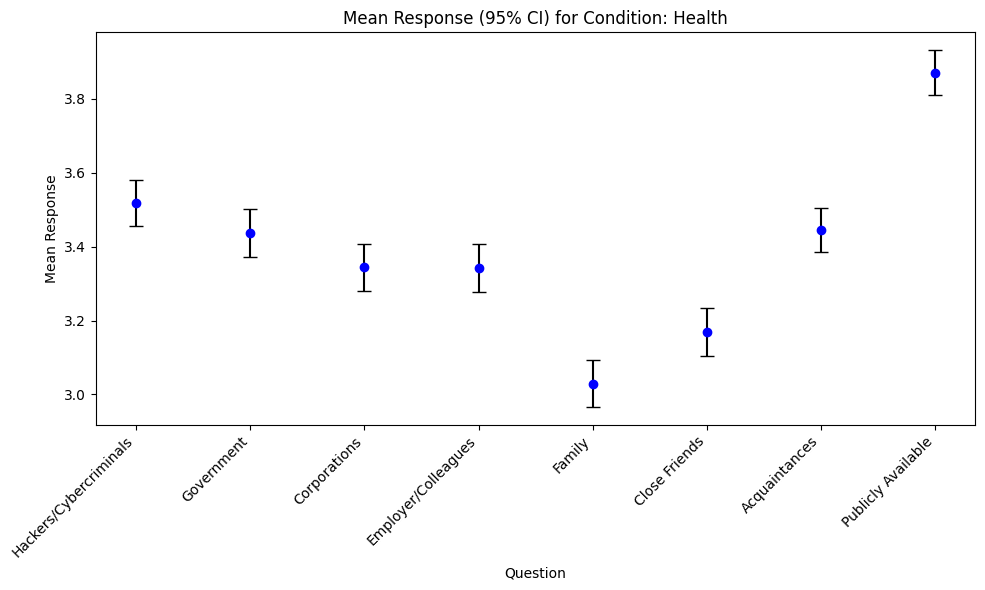

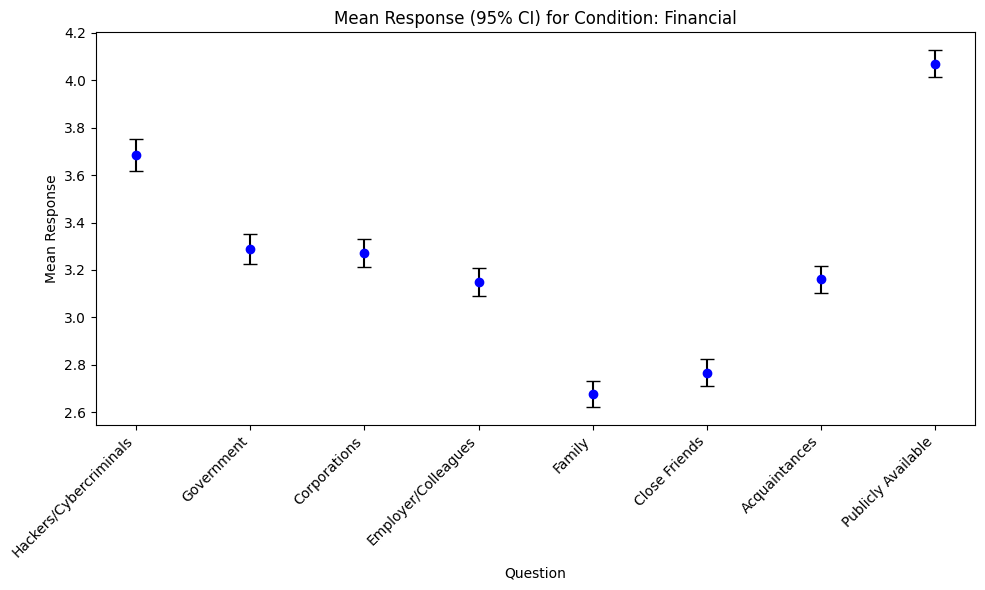

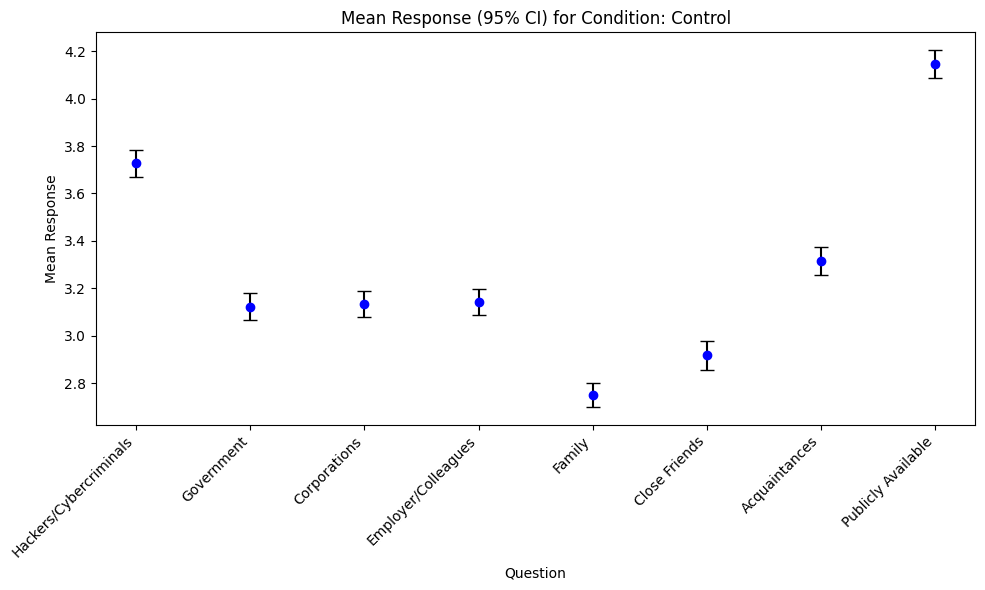

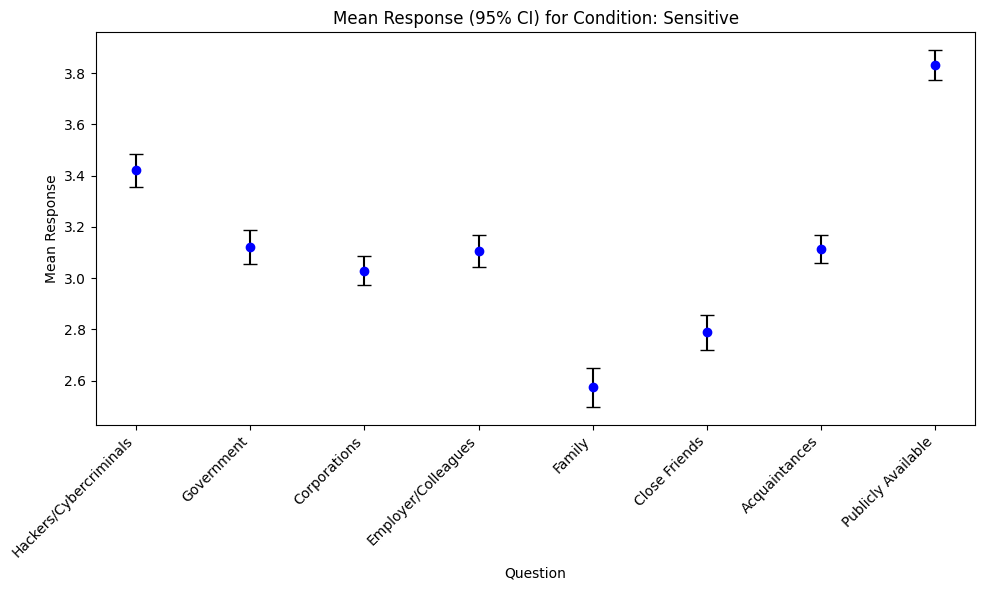

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# Dictionary mapping question codes to descriptive labels
custom_labels = {
    'Q1': 'Hackers/Cybercriminals',
    'Q2': 'Government',
    'Q3': 'Corporations',
    'Q4': 'Employer/Colleagues',
    'Q5': 'Family',
    'Q6': 'Close Friends',
    'Q7': 'Acquaintances',
    'Q8': 'Publicly Available'
}

# We'll assume `grouped_df` has one row per (SyntheticPersonID, Condition),
# with columns: ["SyntheticPersonID", "Condition", "Q1", "Q2", ..., "Q8"].

questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]
conditions = grouped_df["Condition"].unique()

for cond in conditions:
    # Filter data for this condition
    cond_data = grouped_df[grouped_df["Condition"] == cond]

    # Compute means and standard deviations for each question
    mean_vals = cond_data[questions].mean(axis=0)
    std_vals  = cond_data[questions].std(axis=0)

    # Number of SyntheticPersonIDs in this condition
    n = cond_data.shape[0]

    # Standard error for each question
    se_vals = std_vals / np.sqrt(n)  # If n <= 1, be mindful of dividing by zero

    # 95% CI using the t-distribution (two-tailed)
    if n > 1:
        t_multiplier = st.t.ppf(1 - 0.025, df=n-1)
        ci_vals = t_multiplier * se_vals
    else:
        # If there's only one data point in this condition, CI is not meaningful
        ci_vals = np.zeros_like(se_vals)

    # X positions for plotting
    x_positions = np.arange(len(questions))

    # Create the plot
    plt.figure(figsize=(10,6))
    plt.errorbar(
        x_positions,
        mean_vals,
        yerr=ci_vals,
        fmt='o',         # 'o' = circular markers
        capsize=5,       # error bar cap size
        color='blue',
        ecolor='black'   # color for error bar lines
    )

    # Use custom labels for the questions
    question_labels = [custom_labels[q] for q in questions]

    # Labeling
    plt.xticks(x_positions, question_labels, rotation=45, ha='right')
    plt.xlabel("Question")
    plt.ylabel("Mean Response")
    plt.title(f"Mean Response (95% CI) for Condition: {cond}")

    plt.tight_layout()
    plt.show()


In summary, based on your adjusted p‑values, significant differences exist between:

*   Financial vs. Health
*   Financial vs. Sensitive
*   Health vs. Sensitive
*   Control vs. Sensitive.


Financial vs. Control and Health vs. Control do not show significant differences after adjustment.

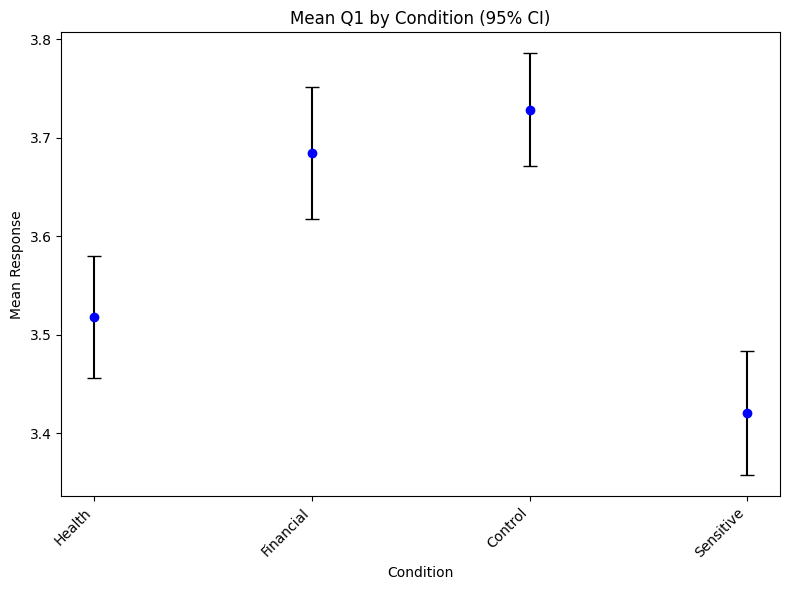

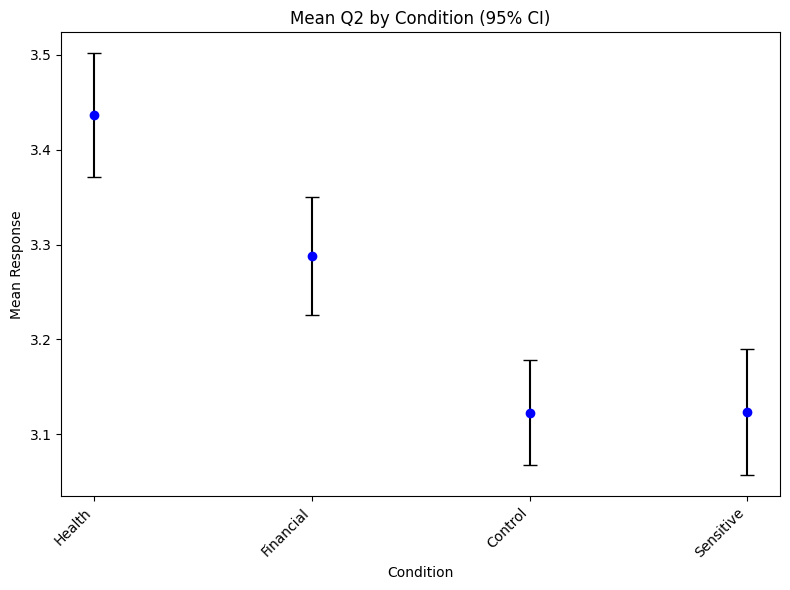

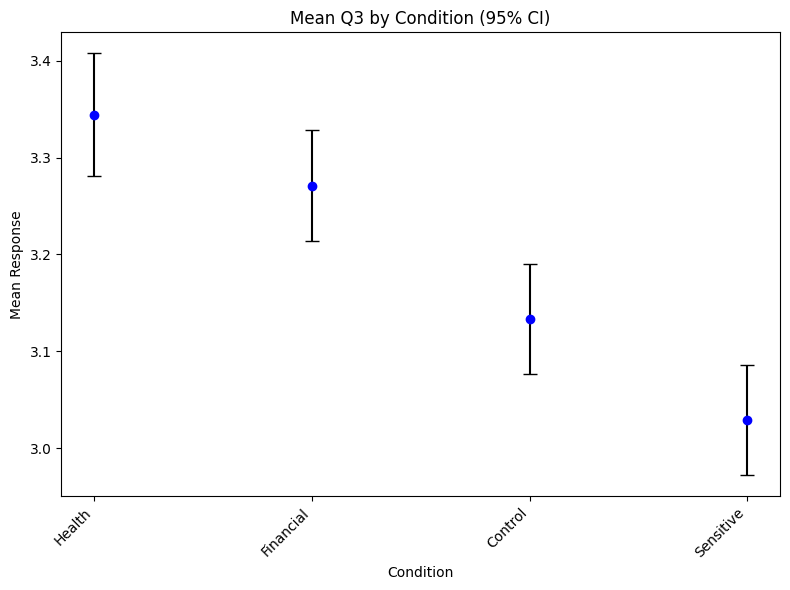

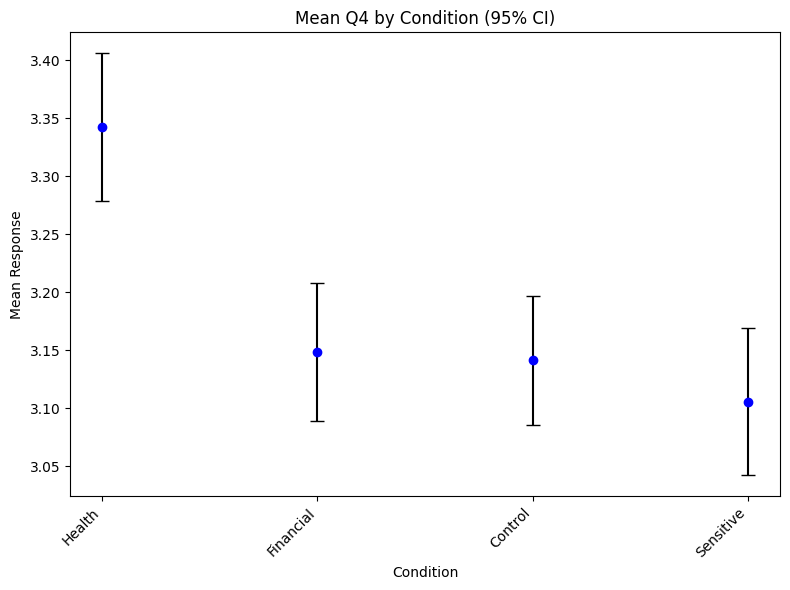

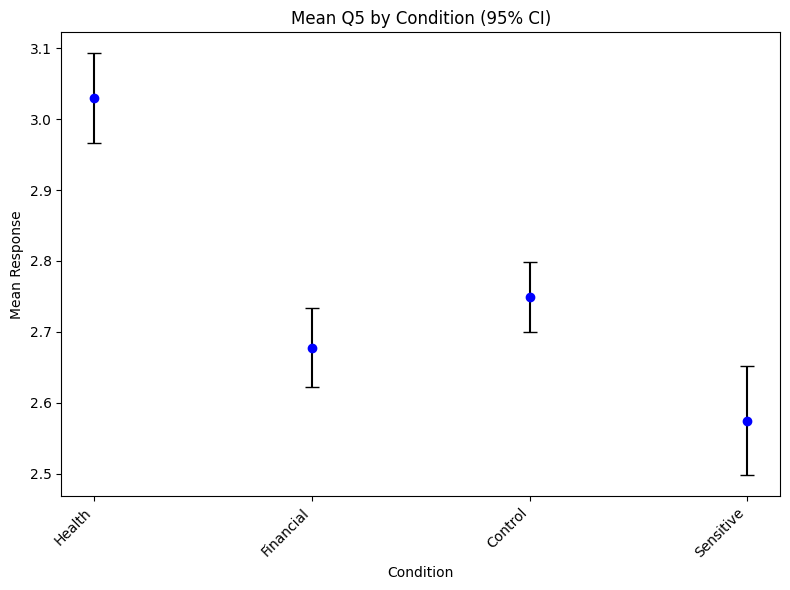

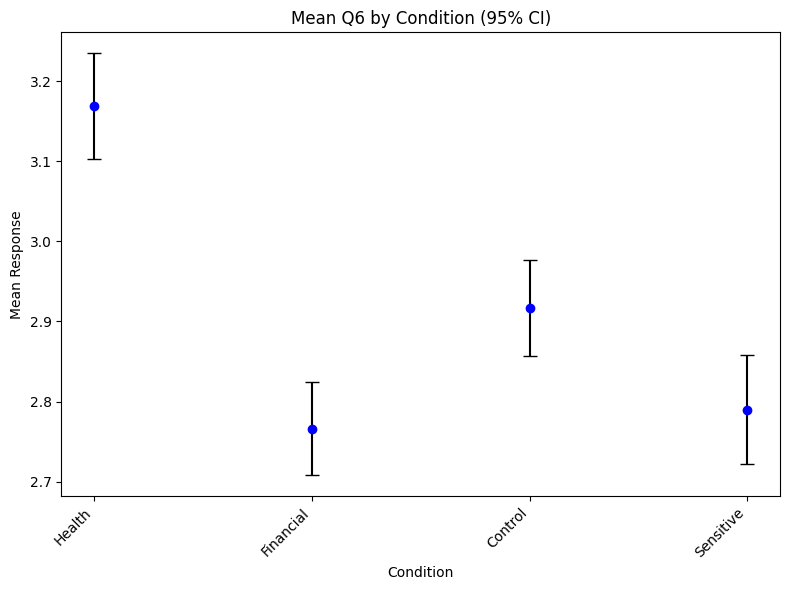

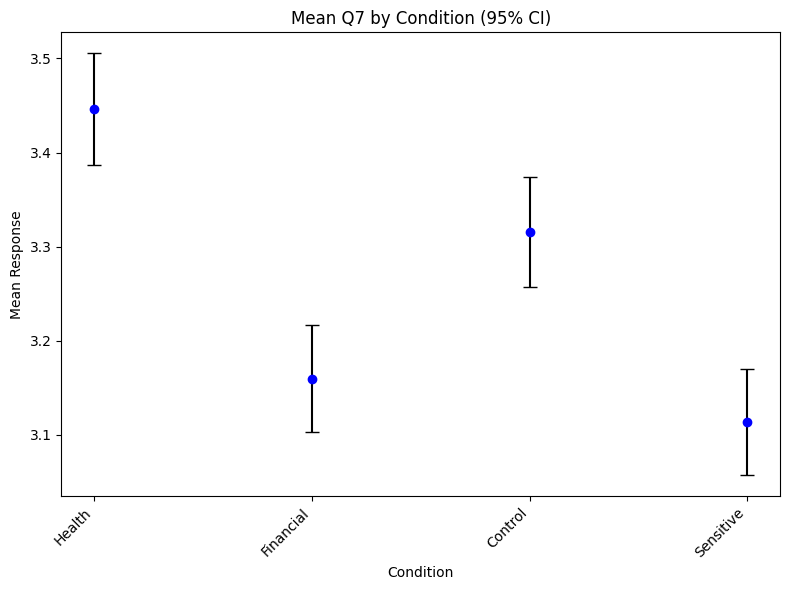

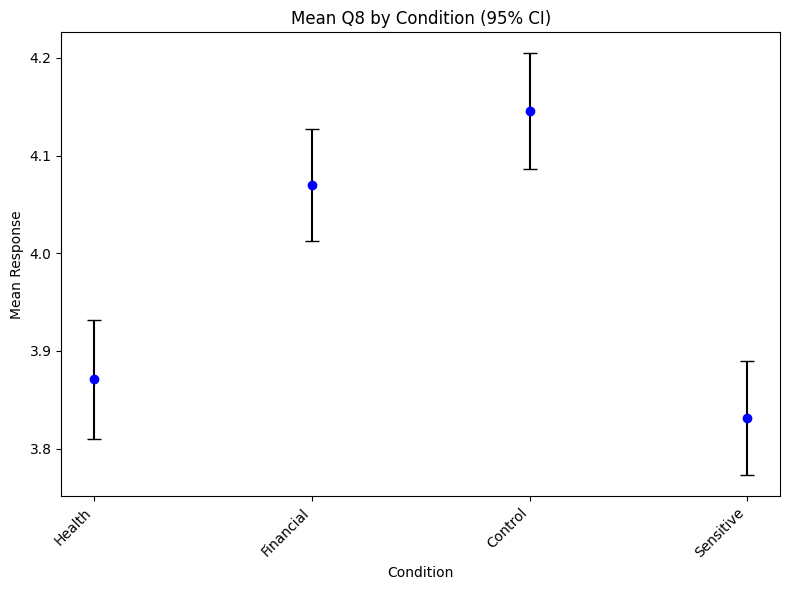

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# We assume grouped_df has one row per (SyntheticPersonID, Condition),
# including averaged columns ["Q1", ..., "Q8"].

questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]
conditions = grouped_df["Condition"].unique()

for question in questions:
    # Prepare lists to store the mean and CI for each condition
    means = []
    ci_vals = []

    for cond in conditions:
        # Extract data for this question in the current condition
        cond_data = grouped_df.loc[grouped_df["Condition"] == cond, question].dropna()
        mean_val = cond_data.mean()
        std_val = cond_data.std()
        n = cond_data.shape[0]

        # Compute 95% CI using the t-distribution
        if n > 1:
            se_val = std_val / np.sqrt(n)
            t_multiplier = st.t.ppf(1 - 0.025, df=n-1)  # 95% CI
            ci = t_multiplier * se_val
        else:
            # If there's only one data point, the CI can't be computed meaningfully
            ci = 0.0

        means.append(mean_val)
        ci_vals.append(ci)

    # Create a figure for this question
    plt.figure(figsize=(8,6))
    x_positions = np.arange(len(conditions))

    # Plot means with error bars only (no bars)
    plt.errorbar(
        x_positions,
        means,
        yerr=ci_vals,
        fmt='o',        # 'o' = circular marker
        capsize=5,      # length of the error bar caps
        color='blue',
        ecolor='black'  # color for the error bars
    )

    # Labeling
    plt.xticks(x_positions, conditions, rotation=45, ha='right')
    plt.xlabel("Condition")
    plt.ylabel("Mean Response")
    plt.title(f"Mean {question} by Condition (95% CI)")

    plt.tight_layout()
    plt.show()

In [11]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import itertools

# Define the questions and the demographic columns you want to analyze
questions = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

# List of demographic columns (categorical) from the Prolific export.
# Update this list based on the columns available in your prolific_export.
demographic_vars = ["Sex", "Ethnicity simplified", "Country of residence", "Language", "Employment status"]

# Prepare a list to store the t-test results
results = []

# Loop over each demographic variable
for demo in demographic_vars:
    # Get the unique groups in this demographic (drop missing values)
    groups = merged_df[demo].dropna().unique()

    # If there are less than 2 groups, skip this demographic.
    if len(groups) < 2:
        continue

    # For each question, perform pairwise comparisons between groups in this demographic.
    for question in questions:
        # Use itertools.combinations to get all unique pairwise comparisons.
        for group1, group2 in itertools.combinations(groups, 2):
            # Filter data for each group for the given question
            data1 = merged_df.loc[merged_df[demo] == group1, question].dropna()
            data2 = merged_df.loc[merged_df[demo] == group2, question].dropna()

            # Only perform the t-test if both groups have at least 2 observations
            if len(data1) >= 2 and len(data2) >= 2:
                t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            else:
                t_stat, p_val = np.nan, np.nan  # Not enough data

            results.append((demo, question, group1, group2, t_stat, p_val))

# Convert the results list to a DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=["Demographic", "Question", "Group1", "Group2", "t_stat", "p_value"])

# Optionally, adjust p-values for multiple comparisons using Bonferroni correction.
from statsmodels.stats.multitest import multipletests
adjusted = multipletests(results_df["p_value"].dropna(), method="bonferroni")
# Place adjusted p-values back into our results DataFrame.
# (We need to match the indices since multipletests was applied to non-NaN values.)
results_df.loc[results_df["p_value"].notna(), "p_adjusted"] = adjusted[1]

# Display the results
print("Pairwise t-test results for each question by demographic variable:")
print(results_df)
# get df to csv
results_df.to_csv('t-tests.csv', index=False)

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Pairwise t-test results for each question by demographic variable:
           Demographic Question  \
0                  Sex       Q1   
1                  Sex       Q1   
2                  Sex       Q1   
3                  Sex       Q2   
4                  Sex       Q2   
..                 ...      ...   
475  Employment status       Q8   
476  Employment status       Q8   
477  Employment status       Q8   
478  Employment status       Q8   
479  Employment status       Q8   

                                                Group1  \
0                                               Female   
1                                               Female   
2                                                 Male   
3                                               Female   
4                                               Female   
..                                                 ...   
475  Not in paid work (e.g. homemaker', 'retired or...   
476  Not in paid work (e.g. homemaker', 'retired

## Supervised ML

In [12]:
from sklearn.preprocessing import LabelEncoder

feature_list = ["GENDER", "RACETHN", "EDUCCAT5", "DIVISION", "MARITAL_ACS",
                "CHILDRENCAT", "CITIZEN_REC", "BORN_ACS", "AGE_INT",
                "HIV_STAT", "PREG_STAT", "NumChronicIllness",
                "FAMINC5", "CC_NUM", "FDSTMP_CPS",
                "SEXUALITY", "OWNGUN_GSS", "RELIGCAT"
]

In [13]:
df_synthetic.head()

,,NAME,id,GENDER,AGE,RACETHN,EDUCCAT5,DIVISION,MARITAL_ACS,HHSIZECAT,...,CI_LABEL_OWNGUN_GSS,CI_LABEL_SEXUALITY,CI_LABEL_HIV_STAT,CI_LABEL_PREG_STAT,CI_LABEL_CC_NUM,CI_LABEL_cc_encoded,CI_LABEL_cc_disclosed,CI_LABEL_NumChronicIllness,AGE_INT,Cluster
0,0,Luke Walsh,1,Male,25,White non-Hispanic,Some college,Mountain,Never married,3+,...,is,is,is probably,is probably,is,is probably,is possibly,is probably,20-29,5
1,1,Matilde Izaguirre Checa,2,Female,70,Hispanic,HS Grad,West South Central,Divorced,1,...,is probably,is possibly,is,is,is,is,is,is possibly,70-79,11
2,2,Ryan Smith,3,Male,85,White non-Hispanic,Less than HS,Middle Atlantic,Now married,2,...,is possibly,is probably,is probably,is,is probably,is probably,is probably,is probably,80-89,2
3,3,Matthew Grimes,4,Male,59,White non-Hispanic,HS Grad,Mountain,Now married,2,...,is probably,is probably,is probably,is,is possibly,is probably,is,is probably,50-59,12
4,4,Miraan Rama,5,Female,19,Asian,Some college,Pacific,Never married,1,...,is probably,is,is probably,is,is probably,is probably,is probably,is,10-19,9


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [15]:
import pandas as pd

# 1) Merge df_synthetic and df_avg on their ID columns, using suffixes to keep them distinct initially.
df_merged = pd.merge(
    df_synthetic,
    df_avg,
    how="left",  # or "inner" if you only want rows with a matching ID in df_avg
    left_on="id",
    right_on="SyntheticPersonID",
    suffixes=("", "_drop")  # Keep df_synthetic columns as-is, add "_drop" to df_avg duplicates
)

# 2) If you prefer to keep the question columns from df_avg and drop the old ones from df_synthetic:
#    (assuming df_synthetic might already have Q1..Q8 but we want the new ones from df_avg)
cols_to_drop = [col for col in df_merged.columns if col.endswith("_drop")]
df_final = df_merged.drop(columns=cols_to_drop)
df_final = df_final.fillna(0)

# 3) Inspect the final result
print(df_final.head())

                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...  \
0  Some college            Mountain  Never married        3+  ...   
1       HS Grad  West South Central       Divorced         1  ...   
2  Less than HS     Middle Atlantic    Now married         2  ...   
3       HS Grad            Mountain    Now married         2  ...   
4  Some college             Pacific  Never married         1  ...   

  SyntheticPersonID   Q1   Q2   Q3   Q4   Q5   Q6   Q7   Q8 avg_harm  
0               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0  
1               0.0  0

In [16]:
train_data = df_final[df_final['Q1'] > 0]
predict_data = df_final[df_final['Q1'] == 0]

X_train = train_data[feature_list]
y_train = train_data['Q1']

onehot_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore',
    drop='first'
)

X_train_encoded = onehot_encoder.fit_transform(X_train.astype(str))

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

models = [
    ('RandomForest', RandomForestRegressor(n_estimators=100)),
    ('GradientBoosting', GradientBoostingRegressor()),
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('DecisionTree', DecisionTreeRegressor()),
    ('SVR', SVR())
]

def evaluate_model(model_name, model, X_train, y_train):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    r2 = r2_score(y_train, y_train_pred)
    print(f'Model: {model_name}')
    print(f'MSE on training data: {mse}')
    print(f'R^2 on training data: {r2}\n')

for name, model in models:
    evaluate_model(name, model, X_train_encoded, y_train_scaled)

KeyboardInterrupt: 

In [17]:
questions = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
for q in questions:

  train_data = df_final[df_final[q] > 0]
  predict_data = df_final[df_final[q] == 0]

  X_train = train_data[feature_list]
  y_train = train_data[q]

  onehot_encoder = OneHotEncoder(
      sparse_output=False,
      handle_unknown='ignore',
      drop='first'
  )

  X_train_encoded = onehot_encoder.fit_transform(X_train.astype(str))

  scaler = StandardScaler()
  y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

  models = [
      ('DecisionTree', DecisionTreeRegressor())
  ]

  def evaluate_model(model_name, model, X_train, y_train):
      model.fit(X_train, y_train)
      y_train_pred = model.predict(X_train)
      mse = mean_squared_error(y_train, y_train_pred)
      r2 = r2_score(y_train, y_train_pred)
      print(f'Model: {model_name}')
      print(f'MSE on training data: {mse}')
      print(f'R^2 on training data: {r2}\n')

  for name, model in models:
      evaluate_model(name, model, X_train_encoded, y_train_scaled)


  best_model = DecisionTreeRegressor(
      max_depth=30,
      max_features=None,
      min_samples_leaf=4,
      min_samples_split=5,
      random_state=42
  )
  best_model.fit(X_train_encoded, y_train_scaled)

  X_predict = predict_data[feature_list]
  X_predict_encoded = onehot_encoder.transform(X_predict.astype(str))
  predicted_scores_scaled = best_model.predict(X_predict_encoded)

  predicted_scores = scaler.inverse_transform(predicted_scores_scaled.reshape(-1, 1)).flatten()

  df_final.loc[df_final[q] == 0, q] = predicted_scores

  print(df_final.head())

Model: DecisionTree
MSE on training data: 8.804251174341649e-35
R^2 on training data: 1.0



/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...  \
0  Some college            Mountain  Never married        3+  ...   
1       HS Grad  West South Central       Divorced         1  ...   
2  Less than HS     Middle Atlantic    Now married         2  ...   
3       HS Grad            Mountain    Now married         2  ...   
4  Some college             Pacific  Never married         1  ...   

  SyntheticPersonID        Q1   Q2   Q3   Q4   Q5   Q6   Q7   Q8 avg_harm  
0               0.0  3.416667  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0  
1           

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...  \
0  Some college            Mountain  Never married        3+  ...   
1       HS Grad  West South Central       Divorced         1  ...   
2  Less than HS     Middle Atlantic    Now married         2  ...   
3       HS Grad            Mountain    Now married         2  ...   
4  Some college             Pacific  Never married         1  ...   

  SyntheticPersonID        Q1        Q2   Q3   Q4   Q5   Q6   Q7   Q8 avg_harm  
0               0.0  3.416667  3.392857  0.0  0.0  0.0  0.0  0.0  0.0      0.0  
1 

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...  \
0  Some college            Mountain  Never married        3+  ...   
1       HS Grad  West South Central       Divorced         1  ...   
2  Less than HS     Middle Atlantic    Now married         2  ...   
3       HS Grad            Mountain    Now married         2  ...   
4  Some college             Pacific  Never married         1  ...   

  SyntheticPersonID        Q1        Q2        Q3   Q4   Q5   Q6   Q7   Q8  \
0               0.0  3.416667  3.392857  2.604167  0.0  0.0  0.0  0.0  0.0   
1       

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...  \
0  Some college            Mountain  Never married        3+  ...   
1       HS Grad  West South Central       Divorced         1  ...   
2  Less than HS     Middle Atlantic    Now married         2  ...   
3       HS Grad            Mountain    Now married         2  ...   
4  Some college             Pacific  Never married         1  ...   

  SyntheticPersonID        Q1        Q2        Q3        Q4   Q5   Q6   Q7  \
0               0.0  3.416667  3.392857  2.604167  3.041667  0.0  0.0  0.0   
1       

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...  \
0  Some college            Mountain  Never married        3+  ...   
1       HS Grad  West South Central       Divorced         1  ...   
2  Less than HS     Middle Atlantic    Now married         2  ...   
3       HS Grad            Mountain    Now married         2  ...   
4  Some college             Pacific  Never married         1  ...   

  SyntheticPersonID        Q1        Q2        Q3        Q4        Q5   Q6  \
0               0.0  3.416667  3.392857  2.604167  3.041667  2.375000  0.0   
1       

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...  \
0  Some college            Mountain  Never married        3+  ...   
1       HS Grad  West South Central       Divorced         1  ...   
2  Less than HS     Middle Atlantic    Now married         2  ...   
3       HS Grad            Mountain    Now married         2  ...   
4  Some college             Pacific  Never married         1  ...   

  SyntheticPersonID        Q1        Q2        Q3        Q4        Q5  \
0               0.0  3.416667  3.392857  2.604167  3.041667  2.375000   
1               0.

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...  \
0  Some college            Mountain  Never married        3+  ...   
1       HS Grad  West South Central       Divorced         1  ...   
2  Less than HS     Middle Atlantic    Now married         2  ...   
3       HS Grad            Mountain    Now married         2  ...   
4  Some college             Pacific  Never married         1  ...   

  SyntheticPersonID        Q1        Q2        Q3        Q4        Q5  \
0               0.0  3.416667  3.392857  2.604167  3.041667  2.375000   
1               0.

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...  \
0  Some college            Mountain  Never married        3+  ...   
1       HS Grad  West South Central       Divorced         1  ...   
2  Less than HS     Middle Atlantic    Now married         2  ...   
3       HS Grad            Mountain    Now married         2  ...   
4  Some college             Pacific  Never married         1  ...   

  SyntheticPersonID        Q1        Q2        Q3        Q4        Q5  \
0               0.0  3.416667  3.392857  2.604167  3.041667  2.375000   
1               0.

In [19]:
# drop syntheticpersonid column
df_final = df_final.drop(columns=['SyntheticPersonID'])
df_final = df_final.drop(columns=['avg_harm'])

## Graphs

<ipython-input-56-0b92cf9f543d>:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x='RACETHN', y=score_type, hue='SEXUALITY', data=average_scores_by_race_sexuality, palette=palette)


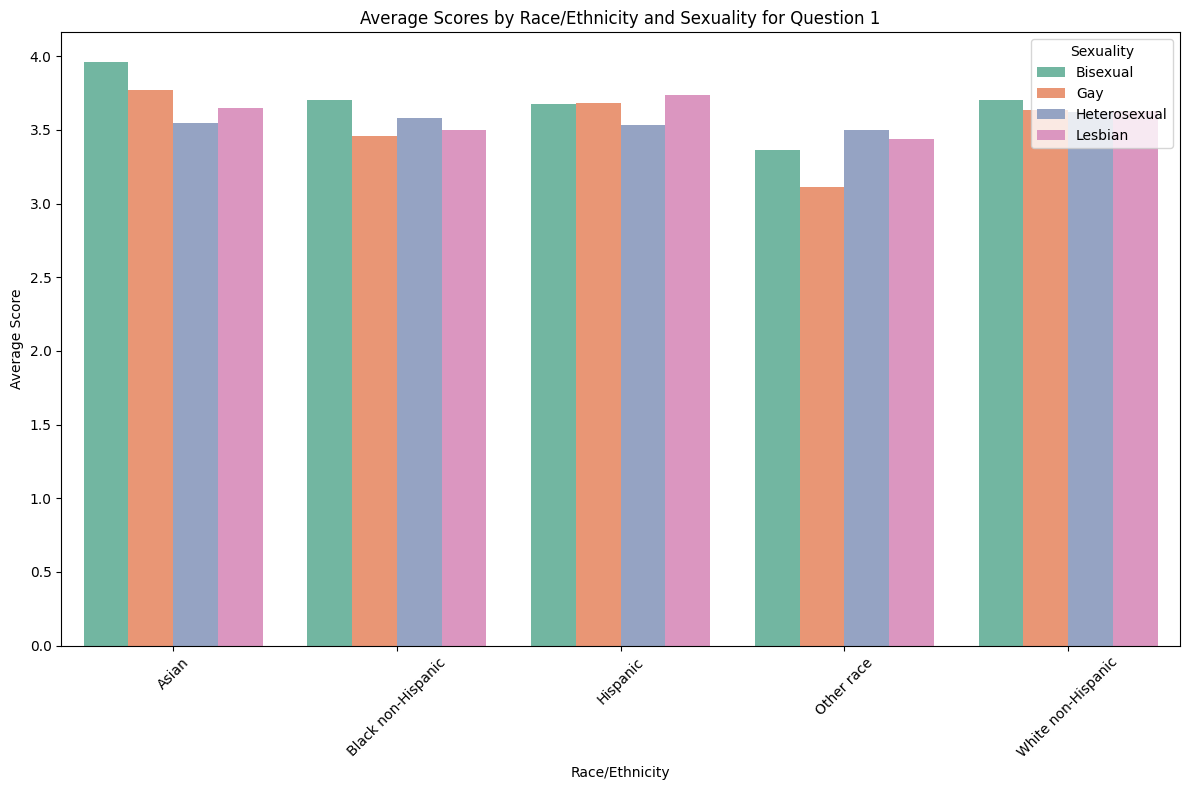

<ipython-input-56-0b92cf9f543d>:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x='RACETHN', y=score_type, hue='SEXUALITY', data=average_scores_by_race_sexuality, palette=palette)


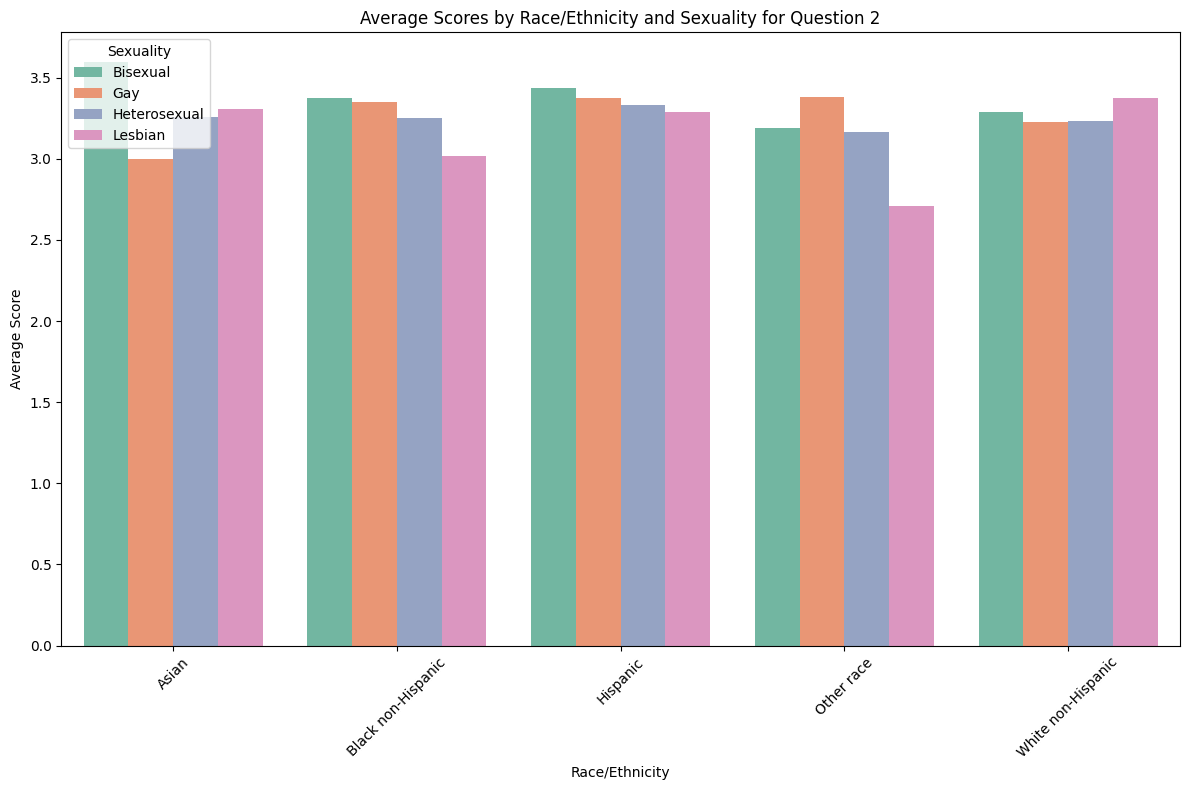

<ipython-input-56-0b92cf9f543d>:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x='RACETHN', y=score_type, hue='SEXUALITY', data=average_scores_by_race_sexuality, palette=palette)


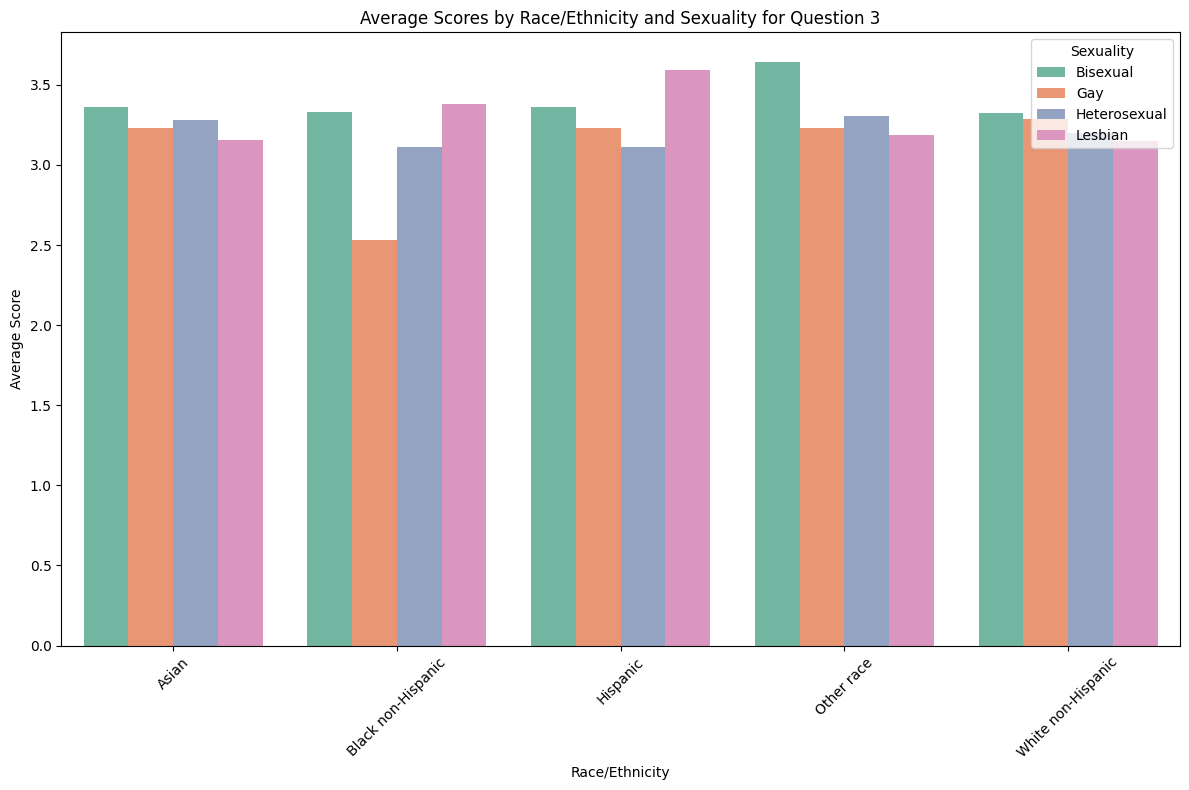

<ipython-input-56-0b92cf9f543d>:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x='RACETHN', y=score_type, hue='SEXUALITY', data=average_scores_by_race_sexuality, palette=palette)


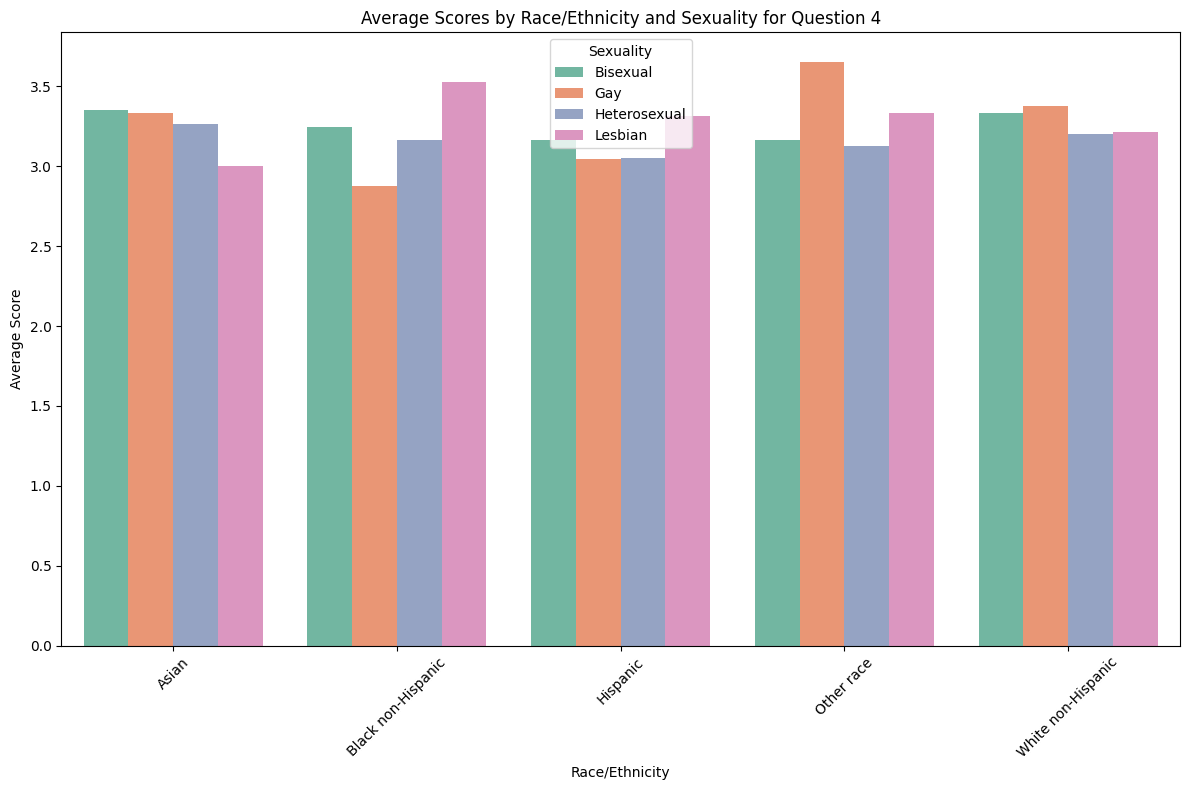

<ipython-input-56-0b92cf9f543d>:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x='RACETHN', y=score_type, hue='SEXUALITY', data=average_scores_by_race_sexuality, palette=palette)


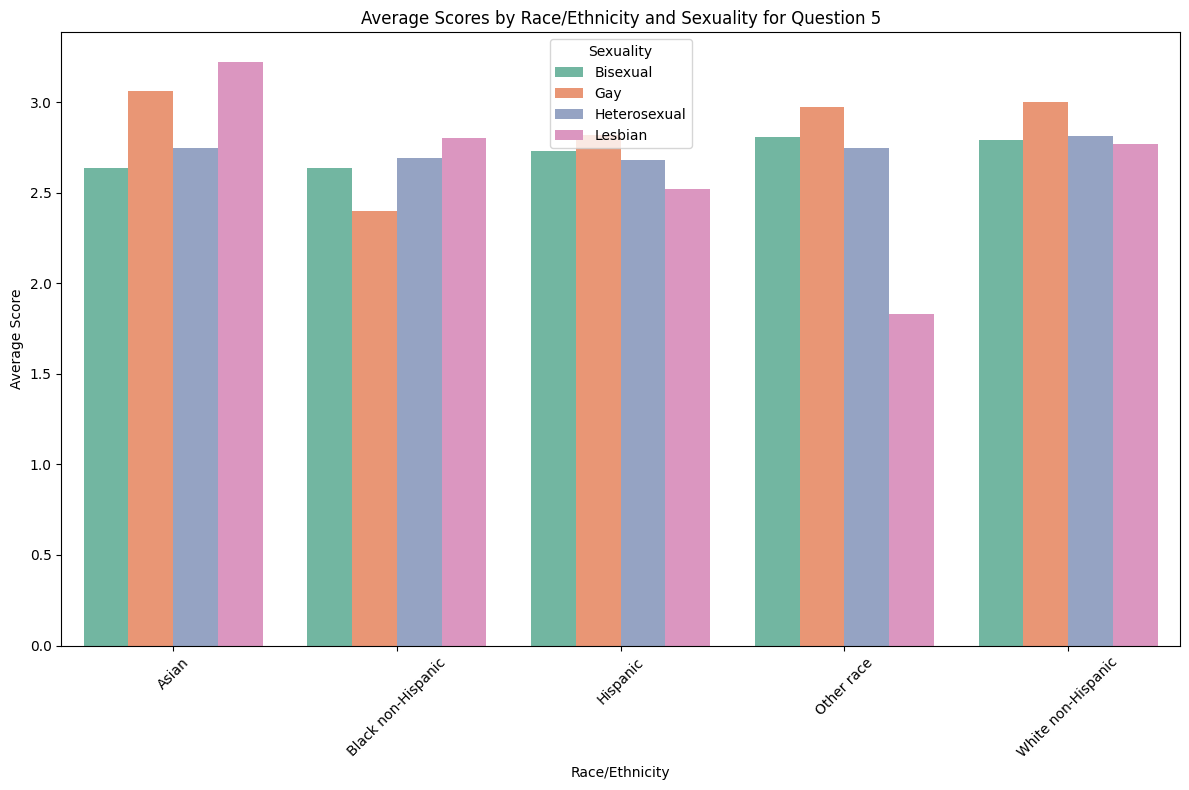

<ipython-input-56-0b92cf9f543d>:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x='RACETHN', y=score_type, hue='SEXUALITY', data=average_scores_by_race_sexuality, palette=palette)


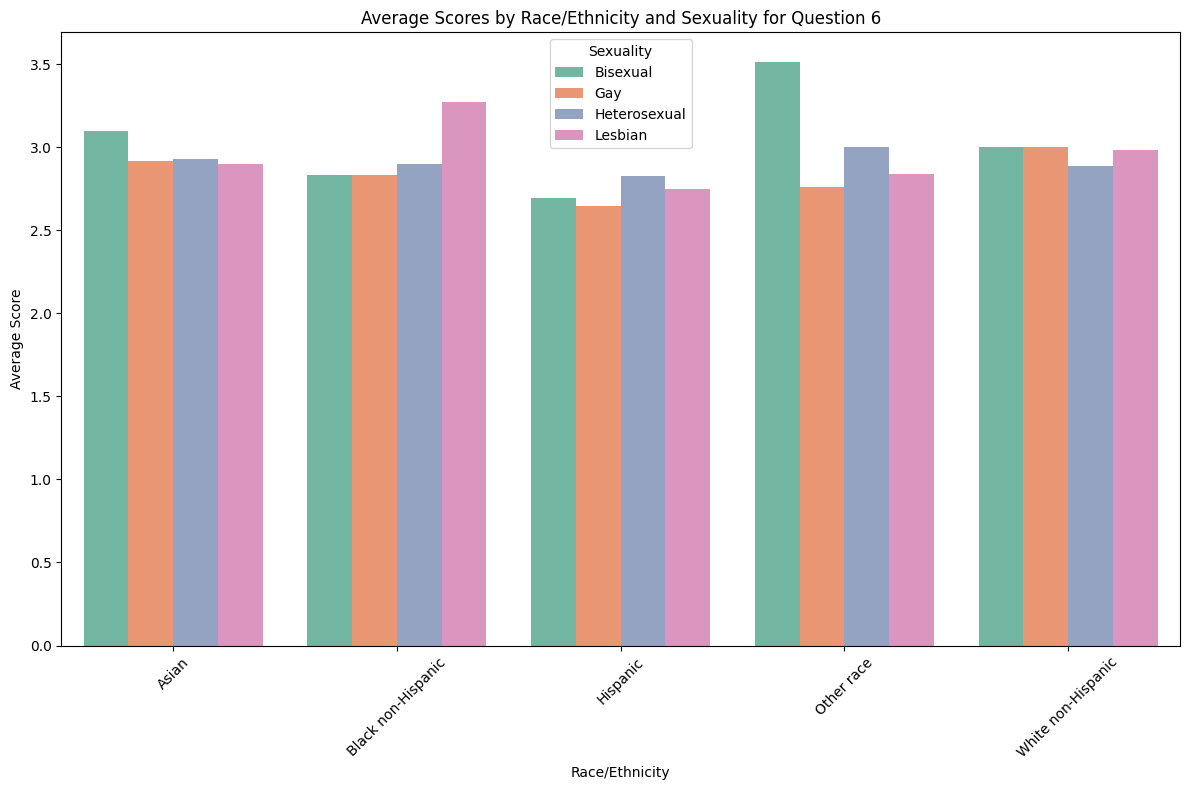

<ipython-input-56-0b92cf9f543d>:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x='RACETHN', y=score_type, hue='SEXUALITY', data=average_scores_by_race_sexuality, palette=palette)


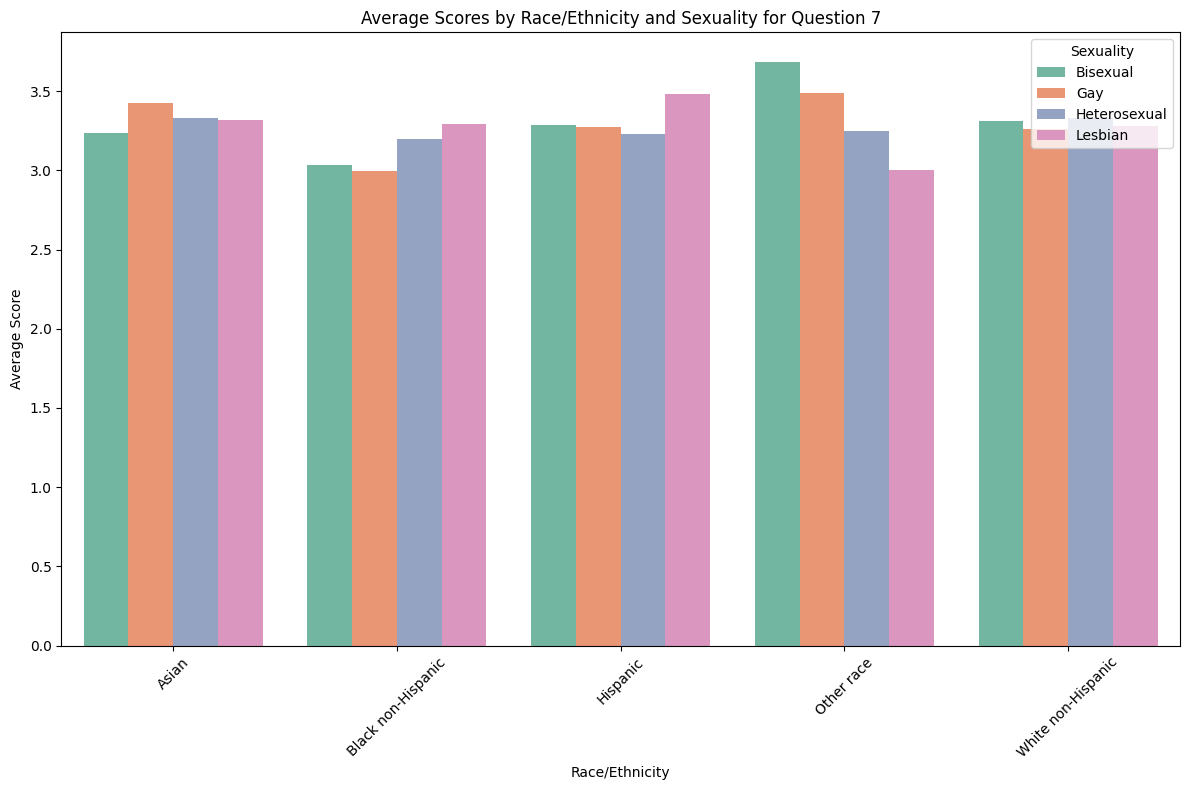

<ipython-input-56-0b92cf9f543d>:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x='RACETHN', y=score_type, hue='SEXUALITY', data=average_scores_by_race_sexuality, palette=palette)


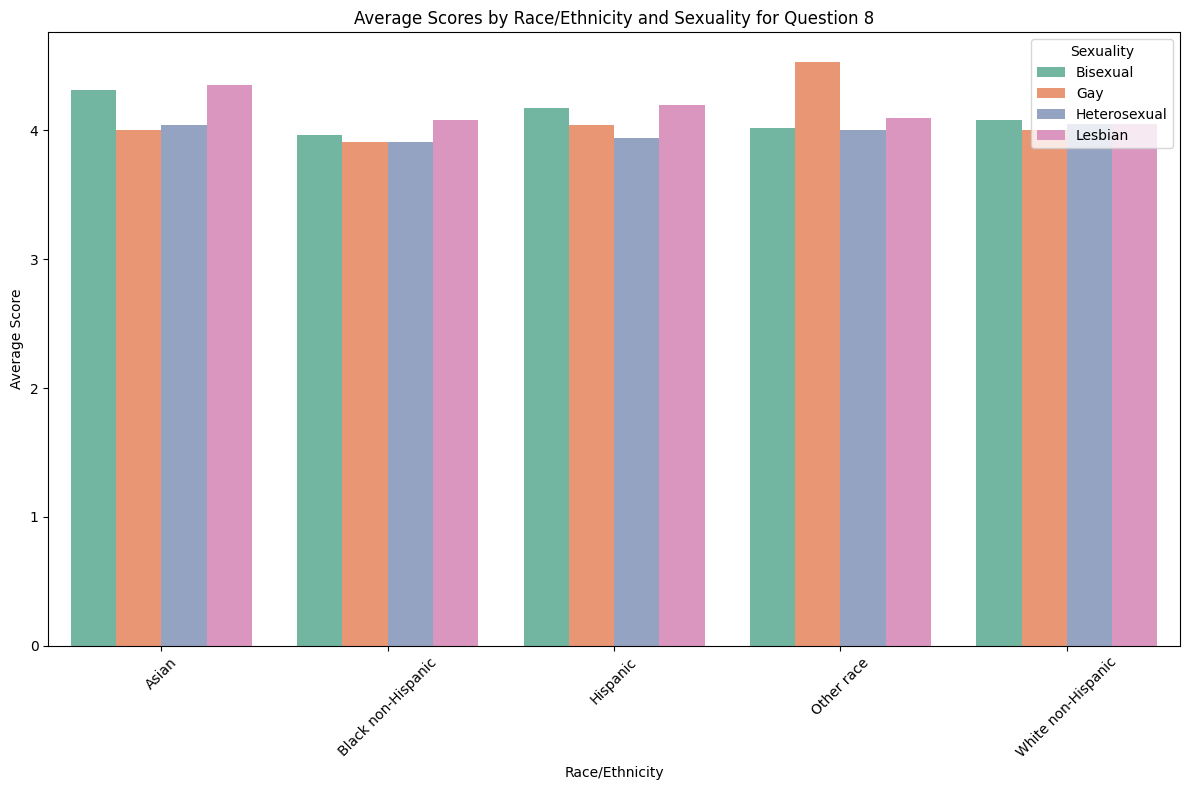

In [56]:
score_types = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
palette = sns.color_palette("Set2")

q = 1

for score_type in score_types:
    average_scores_by_race_sexuality = df_final.groupby(['RACETHN', 'SEXUALITY'])[score_type].median().reset_index()
    plt.figure(figsize=(12, 8))

    sns.barplot(x='RACETHN', y=score_type, hue='SEXUALITY', data=average_scores_by_race_sexuality, palette=palette)

    plt.title(f'Average Scores by Race/Ethnicity and Sexuality for Question {q}')
    q += 1
    plt.xlabel('Race/Ethnicity')
    plt.ylabel('Average Score')
    plt.xticks(rotation=45)
    plt.legend(title='Sexuality')

    plt.tight_layout()
    plt.show()

Does sexuality impact harm?

In [20]:
import itertools
import scipy.stats as stats

score_types = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

# Loop over each question
for score in score_types:
    print(f"\nResults for {score}:")

    # Pairwise t-tests for SEXUALITY
    print("Comparisons by SEXUALITY:")
    sexuality_groups = df_final['SEXUALITY'].dropna().unique()
    for group1, group2 in itertools.combinations(sexuality_groups, 2):
        data1 = df_final[df_final['SEXUALITY'] == group1][score].dropna()
        data2 = df_final[df_final['SEXUALITY'] == group2][score].dropna()
        if len(data1) >= 2 and len(data2) >= 2:
            t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            print(f"  {group1} vs {group2}: t = {t_stat:.3f}, p = {p_val:.3e}")

    # # Pairwise t-tests for RACETHN
    # print("Comparisons by RACETHN:")
    # race_groups = df_final['RACETHN'].dropna().unique()
    # for group1, group2 in itertools.combinations(race_groups, 2):
    #     data1 = df_final[df_final['RACETHN'] == group1][score].dropna()
    #     data2 = df_final[df_final['RACETHN'] == group2][score].dropna()
    #     if len(data1) >= 2 and len(data2) >= 2:
    #         t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
    #         print(f"  {group1} vs {group2}: t = {t_stat:.3f}, p = {p_val:.3e}")



Results for Q1:
Comparisons by SEXUALITY:
  Heterosexual vs Gay: t = 0.020, p = 9.841e-01
  Heterosexual vs Bisexual: t = -4.631, p = 4.155e-06
  Heterosexual vs Lesbian: t = 1.024, p = 3.075e-01
  Gay vs Bisexual: t = -2.687, p = 7.365e-03
  Gay vs Lesbian: t = 0.850, p = 3.962e-01
  Bisexual vs Lesbian: t = 2.876, p = 4.462e-03

Results for Q2:
Comparisons by SEXUALITY:
  Heterosexual vs Gay: t = -0.255, p = 7.985e-01
  Heterosexual vs Bisexual: t = -3.453, p = 5.799e-04
  Heterosexual vs Lesbian: t = -0.574, p = 5.671e-01
  Gay vs Bisexual: t = -1.804, p = 7.161e-02
  Gay vs Lesbian: t = -0.383, p = 7.021e-01
  Bisexual vs Lesbian: t = 0.707, p = 4.806e-01

Results for Q3:
Comparisons by SEXUALITY:
  Heterosexual vs Gay: t = 1.721, p = 8.594e-02
  Heterosexual vs Bisexual: t = -5.635, p = 2.325e-08
  Heterosexual vs Lesbian: t = -1.538, p = 1.262e-01
  Gay vs Bisexual: t = -4.778, p = 2.100e-06
  Gay vs Lesbian: t = -2.202, p = 2.862e-02
  Bisexual vs Lesbian: t = 0.750, p = 4.540e

In [59]:
import itertools
import scipy.stats as stats

score_types = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

# Loop over each harm question
for score in score_types:
    print(f"\n=== T-test Results for {score} ===")

    # 1) Pairwise t-tests by HIV_STAT
    print("Comparisons by HIV_STAT:")
    hiv_groups = df_final['HIV_STAT'].dropna().unique()
    for grp1, grp2 in itertools.combinations(hiv_groups, 2):
        data1 = df_final.loc[df_final['HIV_STAT'] == grp1, score].dropna()
        data2 = df_final.loc[df_final['HIV_STAT'] == grp2, score].dropna()

        # Ensure both groups have at least 2 values to run a t-test
        if len(data1) >= 2 and len(data2) >= 2:
            t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            print(f"  {grp1} vs {grp2}: t = {t_stat:.3f}, p = {p_val:.3e}")
        else:
            print(f"  {grp1} vs {grp2}: Not enough data.")


=== T-test Results for Q1 ===
Comparisons by HIV_STAT:
  negative vs positive: t = -0.171, p = 8.642e-01

=== T-test Results for Q2 ===
Comparisons by HIV_STAT:
  negative vs positive: t = 0.110, p = 9.130e-01

=== T-test Results for Q3 ===
Comparisons by HIV_STAT:
  negative vs positive: t = -0.233, p = 8.158e-01

=== T-test Results for Q4 ===
Comparisons by HIV_STAT:
  negative vs positive: t = 1.262, p = 2.094e-01

=== T-test Results for Q5 ===
Comparisons by HIV_STAT:
  negative vs positive: t = 0.426, p = 6.709e-01

=== T-test Results for Q6 ===
Comparisons by HIV_STAT:
  negative vs positive: t = -1.796, p = 7.498e-02

=== T-test Results for Q7 ===
Comparisons by HIV_STAT:
  negative vs positive: t = 0.204, p = 8.385e-01

=== T-test Results for Q8 ===
Comparisons by HIV_STAT:
  negative vs positive: t = 0.523, p = 6.018e-01


In [60]:
import itertools
import scipy.stats as stats

score_types = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

# Loop over each harm question
for score in score_types:
    print(f"\n=== T-test Results for {score} ===")

    # 1) Pairwise t-tests by HIV_STAT
    print("Comparisons by FAMINC5:")
    hiv_groups = df_final['FAMINC5'].dropna().unique()
    for grp1, grp2 in itertools.combinations(hiv_groups, 2):
        data1 = df_final.loc[df_final['FAMINC5'] == grp1, score].dropna()
        data2 = df_final.loc[df_final['FAMINC5'] == grp2, score].dropna()

        # Ensure both groups have at least 2 values to run a t-test
        if len(data1) >= 2 and len(data2) >= 2:
            t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            print(f"  {grp1} vs {grp2}: t = {t_stat:.3f}, p = {p_val:.3e}")
        else:
            print(f"  {grp1} vs {grp2}: Not enough data.")


=== T-test Results for Q1 ===
Comparisons by FAMINC5:
  $150K or more vs Less than $20K: t = 10.354, p = 6.751e-25
  $150K or more vs $40K to less than $75K: t = 2.848, p = 4.419e-03
  $150K or more vs $20K to less than $40K: t = 5.689, p = 1.340e-08
  $150K or more vs $75K to less than $150K: t = -3.250, p = 1.162e-03
  Less than $20K vs $40K to less than $75K: t = -9.091, p = 1.339e-19
  Less than $20K vs $20K to less than $40K: t = -5.221, p = 1.838e-07
  Less than $20K vs $75K to less than $150K: t = -15.307, p = 8.899e-52
  $40K to less than $75K vs $20K to less than $40K: t = 3.646, p = 2.681e-04
  $40K to less than $75K vs $75K to less than $150K: t = -7.657, p = 2.070e-14
  $20K to less than $40K vs $75K to less than $150K: t = -10.312, p = 9.442e-25

=== T-test Results for Q2 ===
Comparisons by FAMINC5:
  $150K or more vs Less than $20K: t = 1.803, p = 7.145e-02
  $150K or more vs $40K to less than $75K: t = -0.908, p = 3.638e-01
  $150K or more vs $20K to less than $40K: t =

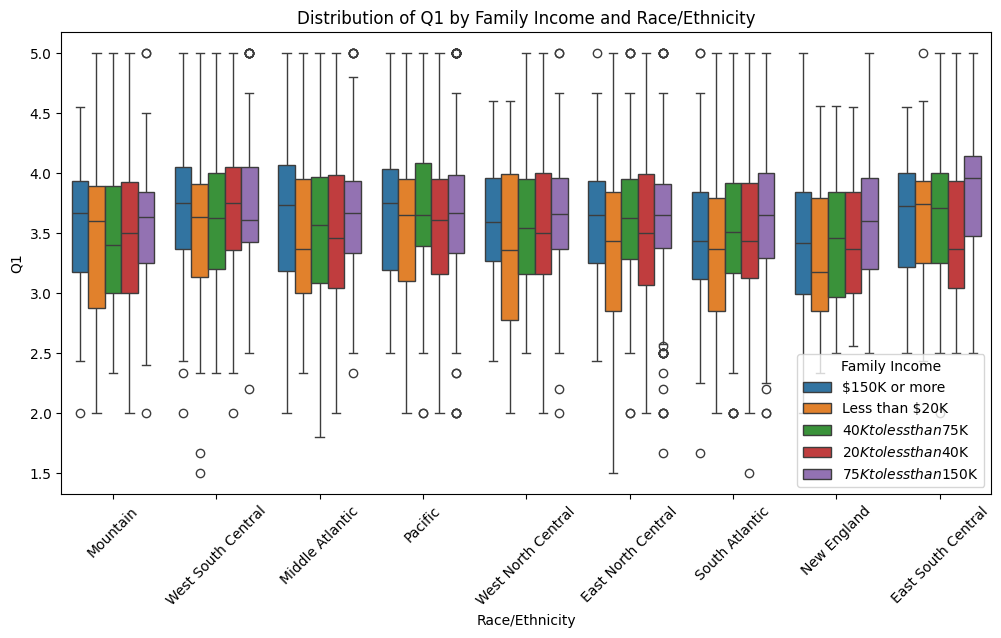

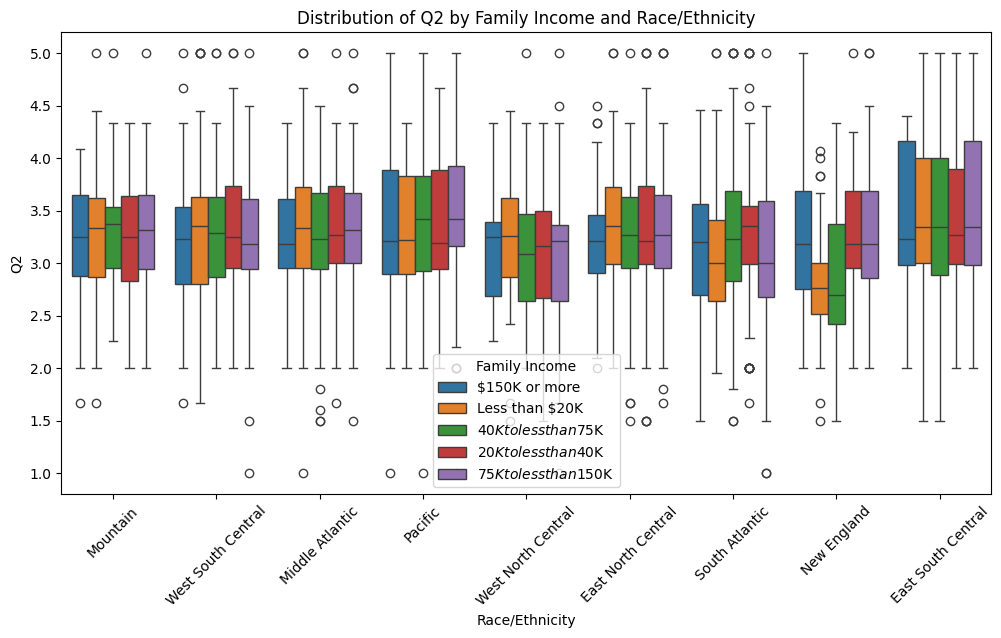

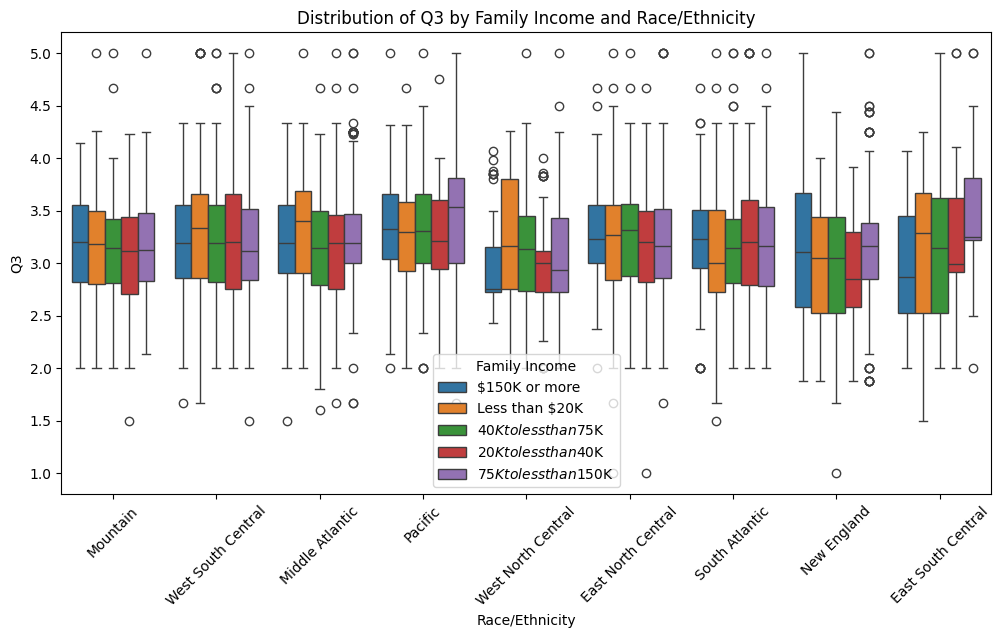

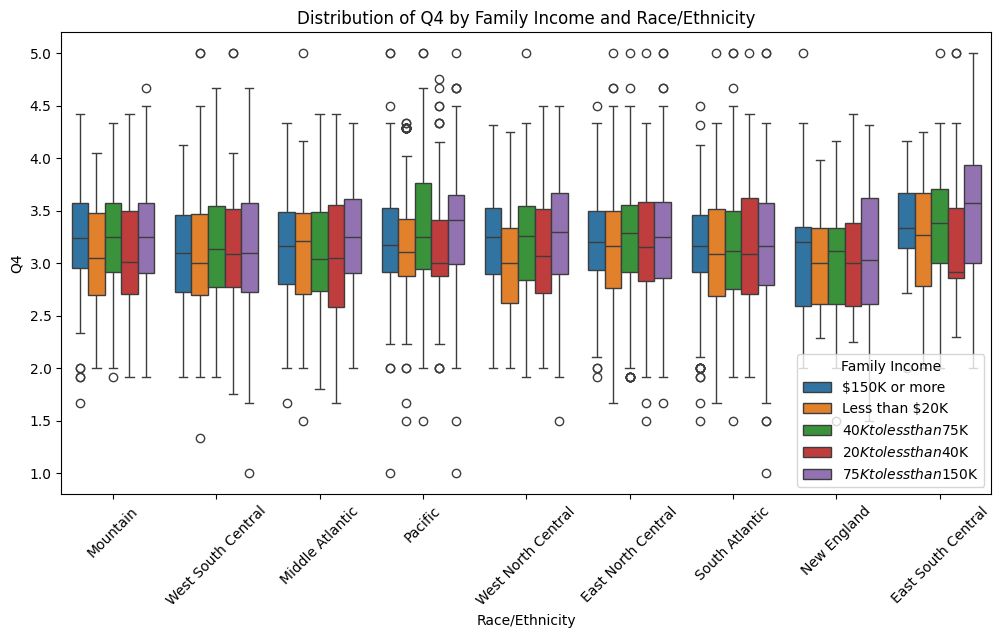

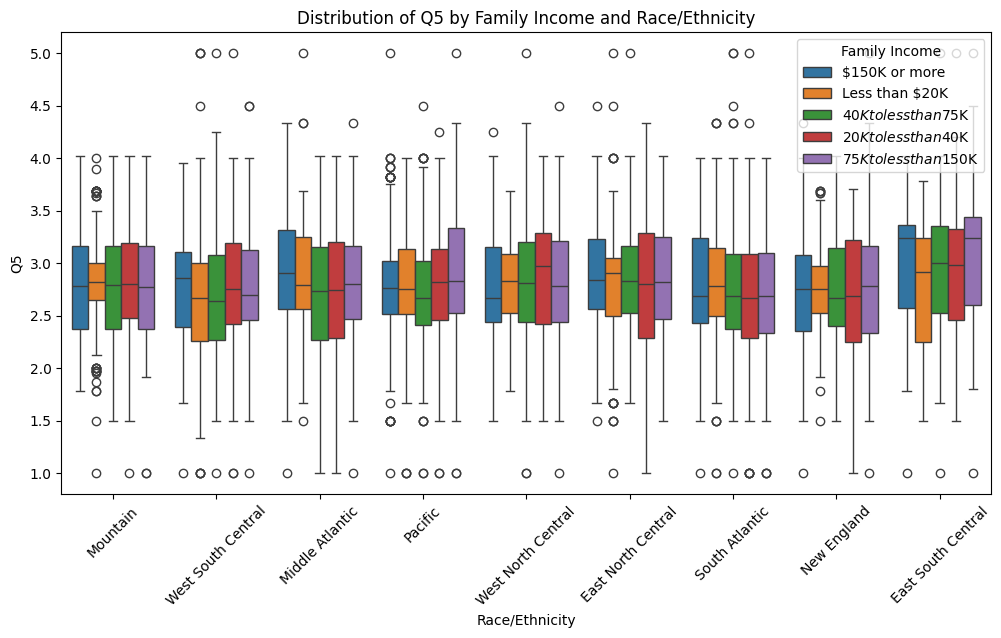

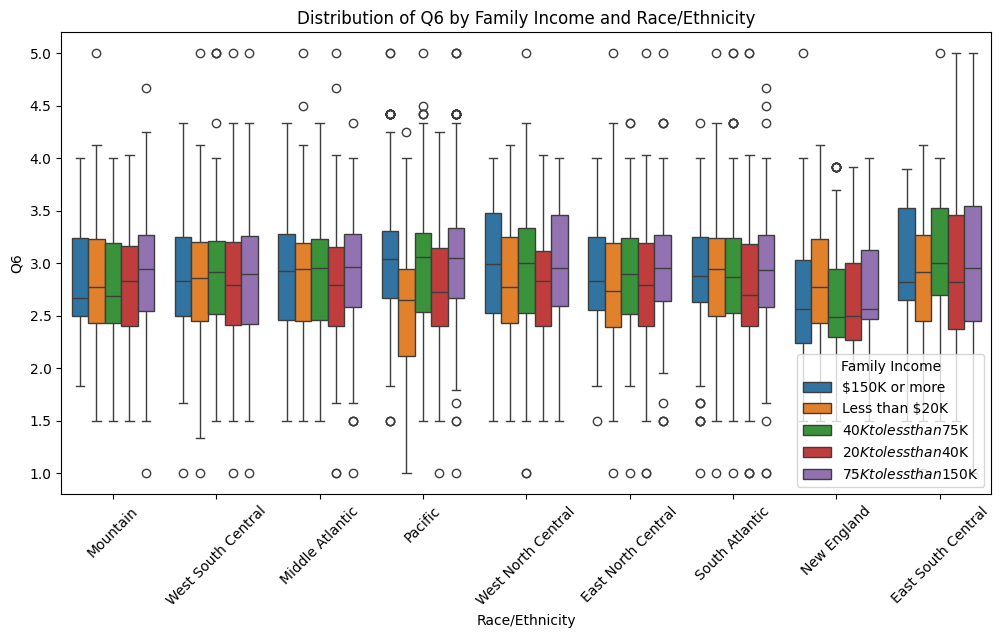

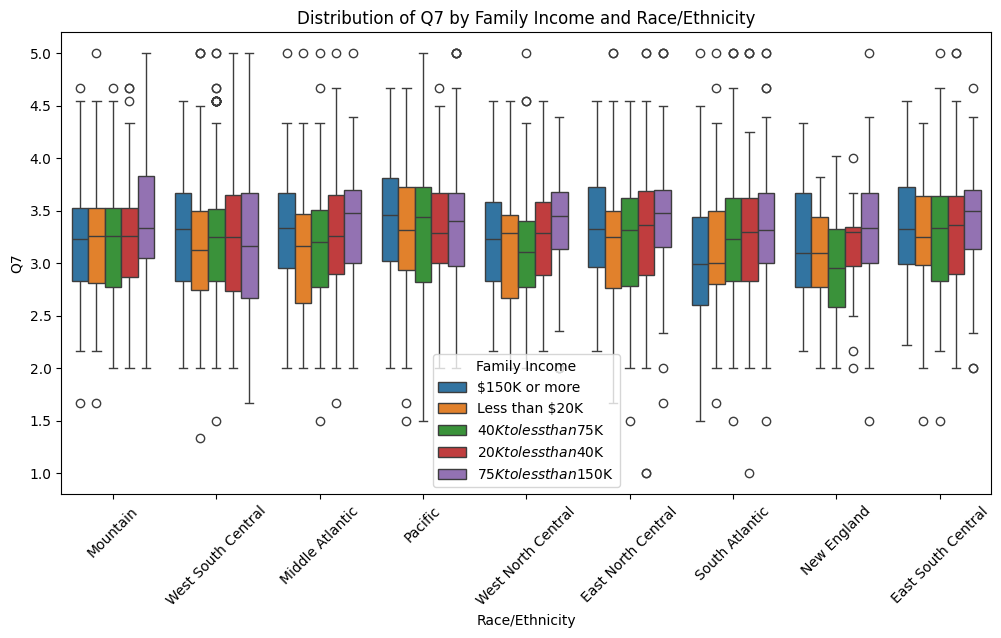

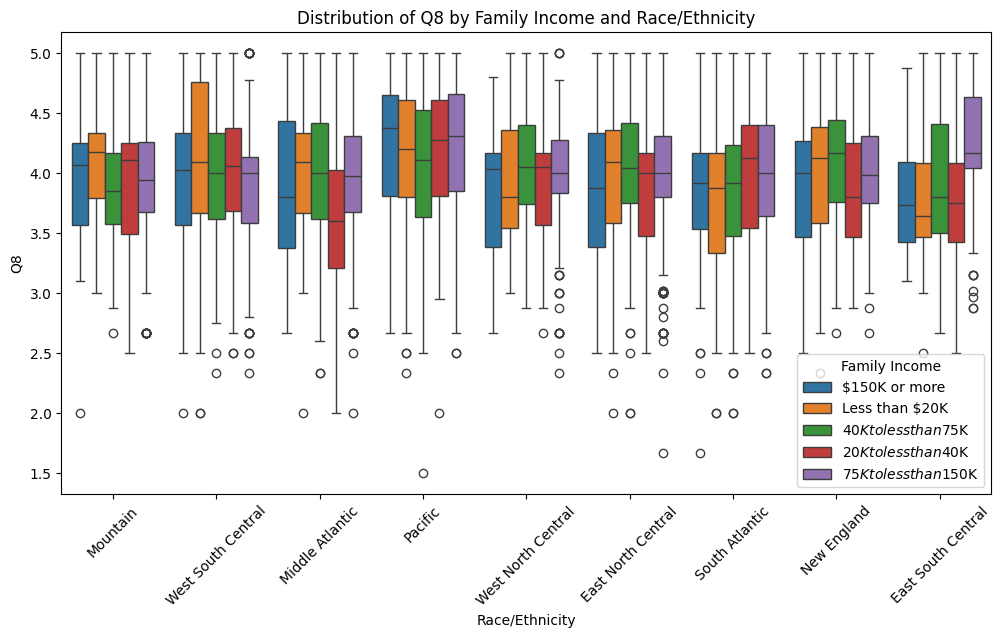

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

score_types = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

for score_type in score_types:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='DIVISION', y=score_type, hue='FAMINC5', data=df_final)
    plt.title(f'Distribution of {score_type} by Family Income and Race/Ethnicity')
    plt.xlabel('Race/Ethnicity')
    plt.ylabel(score_type)
    plt.legend(title='Family Income')
    plt.xticks(rotation=45)
    plt.show()

In [66]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# List of your harm questions
questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]

# We'll loop over each question and fit a model like:
# QX ~ C(HIV_STAT)*C(GENDER) + C(HIV_STAT)*C(RACETHN) + C(HIV_STAT)*C(SEXUALITY)
for q in questions:
    formula = (
        f"{q} ~ C(HIV_STAT)*C(GENDER) "
        f"+ C(HIV_STAT)*C(RACETHN) "
        f"+ C(HIV_STAT)*C(SEXUALITY)"
    )
    model = ols(formula, data=df_final).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print(f"ANOVA for {q} (HIV status interactions):")
    print(anova_table)
    print("\n")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


ANOVA for Q1 (HIV status interactions):
                               sum_sq       df          F        PR(>F)
C(HIV_STAT)                       NaN      1.0        NaN           NaN
C(GENDER)                    1.031297      1.0   3.459178  6.291625e-02
C(RACETHN)                  32.247881      4.0  27.041477  2.061234e-22
C(SEXUALITY)                 7.345514      3.0   8.212780  2.720823e-04
C(HIV_STAT):C(GENDER)        1.084251      1.0   3.636796  5.652991e-02
C(HIV_STAT):C(RACETHN)       1.855918      4.0   1.556281  1.830005e-01
C(HIV_STAT):C(SEXUALITY)     0.074259      3.0   0.083027  9.203269e-01
Residual                  5957.601692  19983.0        NaN           NaN




/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


ANOVA for Q2 (HIV status interactions):
                               sum_sq       df          F        PR(>F)
C(HIV_STAT)                       NaN      1.0        NaN           NaN
C(GENDER)                    7.351555      1.0  26.167008  3.160221e-07
C(RACETHN)                  11.284552      4.0  10.041513  4.072944e-08
C(SEXUALITY)                 4.480533      3.0   5.315980  4.919414e-03
C(HIV_STAT):C(GENDER)        1.152986      1.0   4.103919  4.279721e-02
C(HIV_STAT):C(RACETHN)       1.409422      4.0   1.254169  2.856295e-01
C(HIV_STAT):C(SEXUALITY)     0.355331      3.0   0.421587  6.560110e-01
Residual                  5614.173538  19983.0        NaN           NaN




/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


ANOVA for Q3 (HIV status interactions):
                               sum_sq       df          F        PR(>F)
C(HIV_STAT)                       NaN      1.0        NaN           NaN
C(GENDER)                    7.399024      1.0  30.548239  3.297363e-08
C(RACETHN)                   9.770807      4.0  10.085145  3.748663e-08
C(SEXUALITY)                15.220055      3.0  20.946271  8.178470e-10
C(HIV_STAT):C(GENDER)        0.397629      1.0   1.641685  2.001094e-01
C(HIV_STAT):C(RACETHN)       2.161597      4.0   2.231138  6.305302e-02
C(HIV_STAT):C(SEXUALITY)     0.996982      3.0   1.372075  2.536041e-01
Residual                  4840.039940  19983.0        NaN           NaN




/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


ANOVA for Q4 (HIV status interactions):
                               sum_sq       df          F        PR(>F)
C(HIV_STAT)                       NaN      1.0        NaN           NaN
C(GENDER)                   20.080138      1.0  75.534928  3.862163e-18
C(RACETHN)                  39.594250      4.0  37.235163  4.492368e-31
C(SEXUALITY)                18.490424      3.0  23.184981  8.761028e-11
C(HIV_STAT):C(GENDER)        0.193486      1.0   0.727831  3.935975e-01
C(HIV_STAT):C(RACETHN)       1.108683      4.0   1.042626  3.834517e-01
C(HIV_STAT):C(SEXUALITY)     0.115409      3.0   0.144710  8.652739e-01
Residual                  5312.262878  19983.0        NaN           NaN




/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


ANOVA for Q5 (HIV status interactions):
                               sum_sq       df          F        PR(>F)
C(HIV_STAT)                       NaN      1.0        NaN           NaN
C(GENDER)                   16.643305      1.0  58.359518  2.281531e-14
C(RACETHN)                  42.171325      4.0  36.968292  7.577198e-31
C(SEXUALITY)                 8.424883      3.0   9.847245  5.314981e-05
C(HIV_STAT):C(GENDER)        0.040882      1.0   0.143352  7.049751e-01
C(HIV_STAT):C(RACETHN)       0.201964      4.0   0.177046  9.503129e-01
C(HIV_STAT):C(SEXUALITY)     0.496024      3.0   0.579767  5.600380e-01
Residual                  5698.867506  19983.0        NaN           NaN




/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


ANOVA for Q6 (HIV status interactions):
                               sum_sq       df          F        PR(>F)
C(HIV_STAT)                       NaN      1.0        NaN           NaN
C(GENDER)                    0.076645      1.0   0.266522  6.056804e-01
C(RACETHN)                  33.771216      4.0  29.358518  2.227144e-24
C(SEXUALITY)                17.352454      3.0  20.113473  1.877630e-09
C(HIV_STAT):C(GENDER)        0.807353      1.0   2.807444  9.384342e-02
C(HIV_STAT):C(RACETHN)       1.922260      4.0   1.671089  1.535850e-01
C(HIV_STAT):C(SEXUALITY)     1.066029      3.0   1.235649  2.906682e-01
Residual                  5746.630356  19983.0        NaN           NaN




/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


ANOVA for Q7 (HIV status interactions):
                               sum_sq       df          F        PR(>F)
C(HIV_STAT)                       NaN      1.0        NaN           NaN
C(GENDER)                    0.406088      1.0   1.617649  2.034348e-01
C(RACETHN)                  34.499272      4.0  34.356930  1.260325e-28
C(SEXUALITY)                 0.115167      3.0   0.152922  8.581976e-01
C(HIV_STAT):C(GENDER)        0.869957      1.0   3.465470  6.267736e-02
C(HIV_STAT):C(RACETHN)       1.962703      4.0   1.954605  9.850534e-02
C(HIV_STAT):C(SEXUALITY)     0.208720      3.0   0.277146  7.579471e-01
Residual                  5016.447647  19983.0        NaN           NaN


ANOVA for Q8 (HIV status interactions):
                               sum_sq       df          F        PR(>F)
C(HIV_STAT)                       NaN      1.0        NaN           NaN
C(GENDER)                   18.214321      1.0  69.728470  7.243990e-17
C(RACETHN)                  30.396160      4.0  29.090

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


In [69]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# List of your harm questions
questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]

# We'll loop over each question and fit a model like:
# QX ~ C(HIV_STAT)*C(GENDER) + C(HIV_STAT)*C(RACETHN) + C(HIV_STAT)*C(SEXUALITY)
for q in questions:
    formula = (
        f"{q} ~ C(PREG_STAT)*C(OWNGUN_GSS) "
        f"+ C(PREG_STAT)*C(EDUCCAT5) "
        f"+ C(PREG_STAT)*C(AGE_INT)"
    )
    model = ols(formula, data=df_final).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print(f"ANOVA for {q} (Pregnancy):")
    print(anova_table)
    print("\n")

ANOVA for Q1 (Pregnancy):
                                 sum_sq       df           F         PR(>F)
C(PREG_STAT)                   4.095558      2.0    7.190990   7.552962e-04
C(OWNGUN_GSS)                 48.686100      1.0  170.966305   6.577359e-39
C(EDUCCAT5)                   16.195391      4.0   14.217951   1.366747e-11
C(AGE_INT)                   217.003435      7.0  108.861449  3.168010e-157
C(PREG_STAT):C(OWNGUN_GSS)     0.019176      2.0    0.033669   9.668912e-01
C(PREG_STAT):C(EDUCCAT5)      11.344730      8.0    4.979775   3.483861e-06
C(PREG_STAT):C(AGE_INT)       11.206338     14.0    2.810873   3.248167e-04
Residual                    5684.296889  19961.0         NaN            NaN


ANOVA for Q2 (Pregnancy):
                                 sum_sq       df          F        PR(>F)
C(PREG_STAT)                  24.899177      2.0  45.243136  2.486321e-20
C(OWNGUN_GSS)                  0.514457      1.0   1.869590  1.715374e-01
C(EDUCCAT5)                    1.714461 

/usr/local/lib/python3.11/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


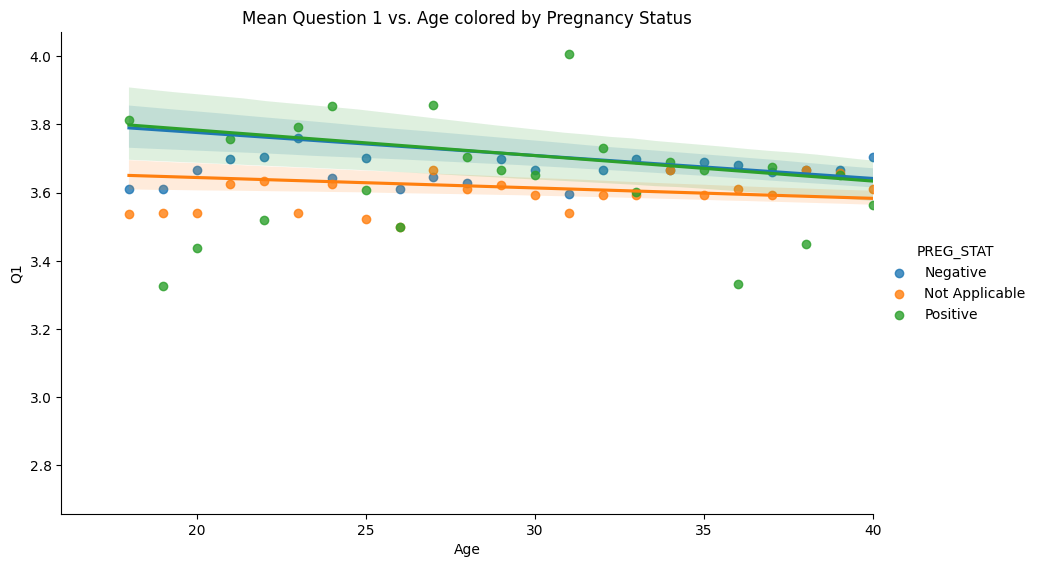

/usr/local/lib/python3.11/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


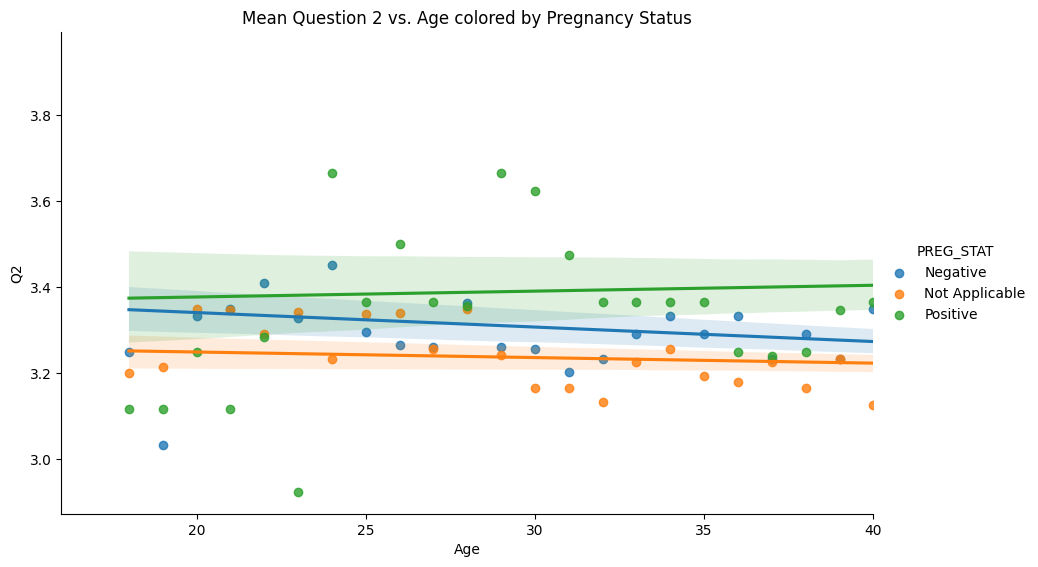

/usr/local/lib/python3.11/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


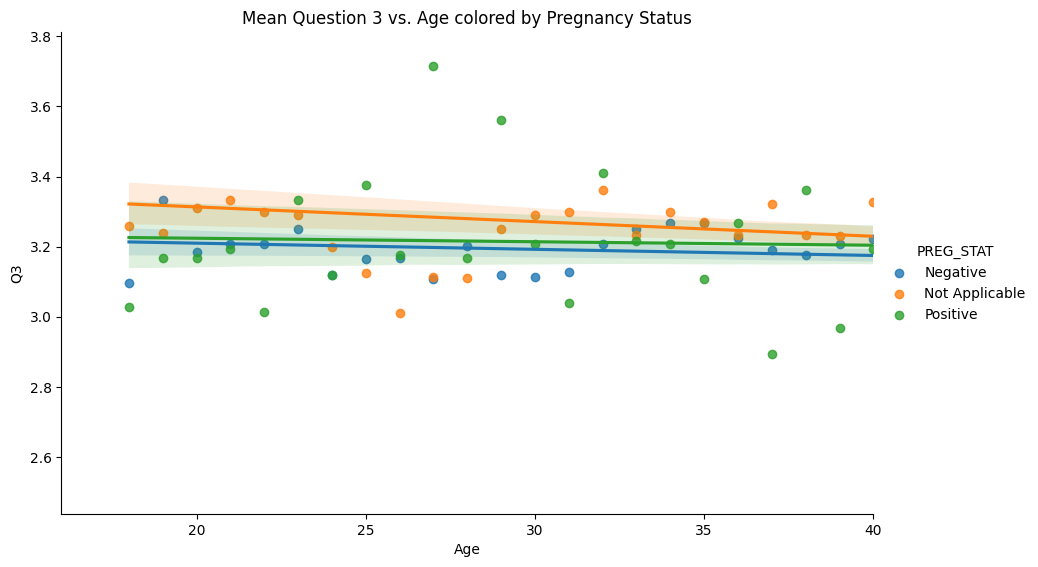

/usr/local/lib/python3.11/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


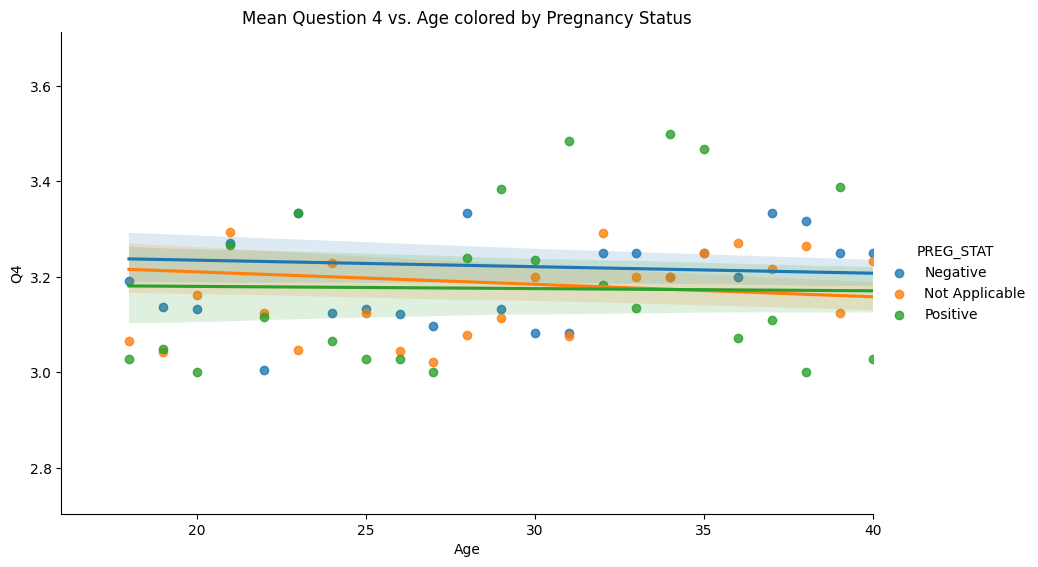

/usr/local/lib/python3.11/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


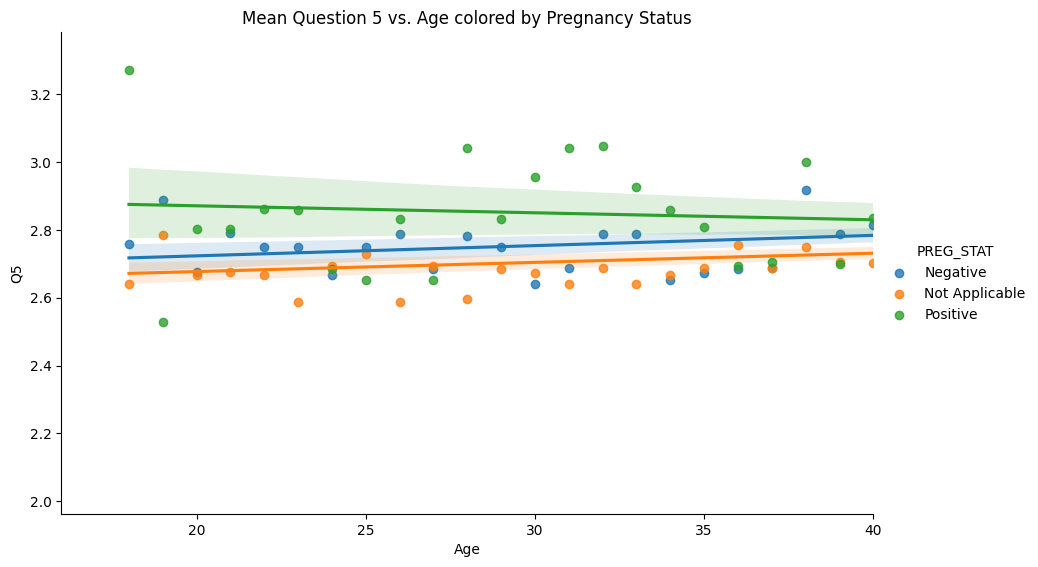

/usr/local/lib/python3.11/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


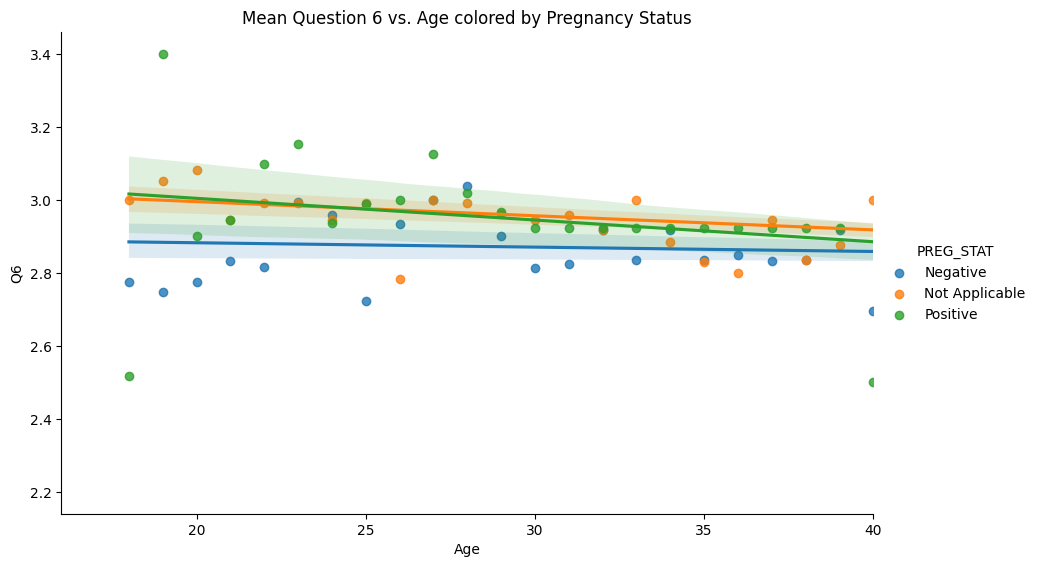

/usr/local/lib/python3.11/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


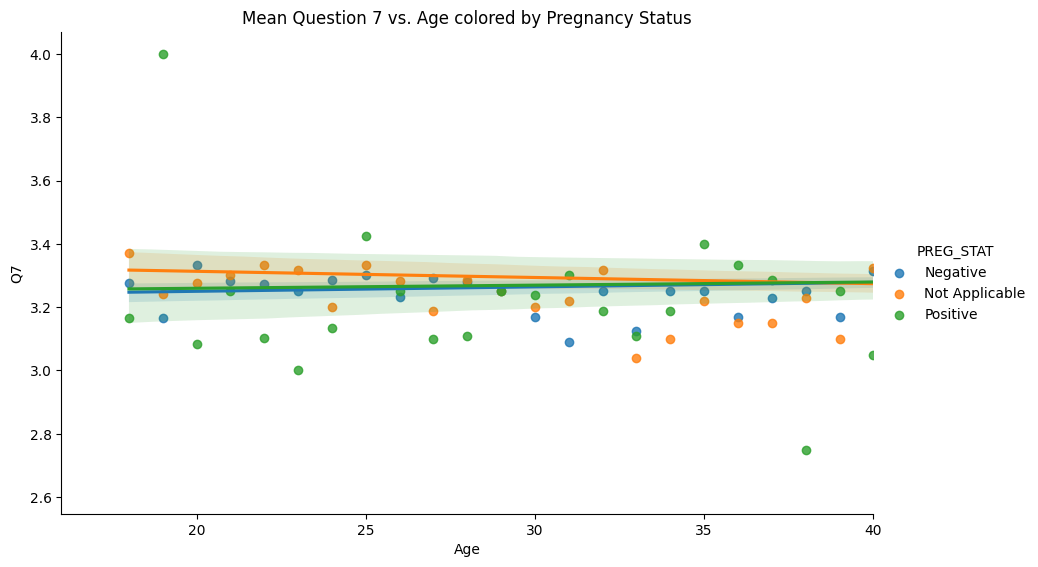

/usr/local/lib/python3.11/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


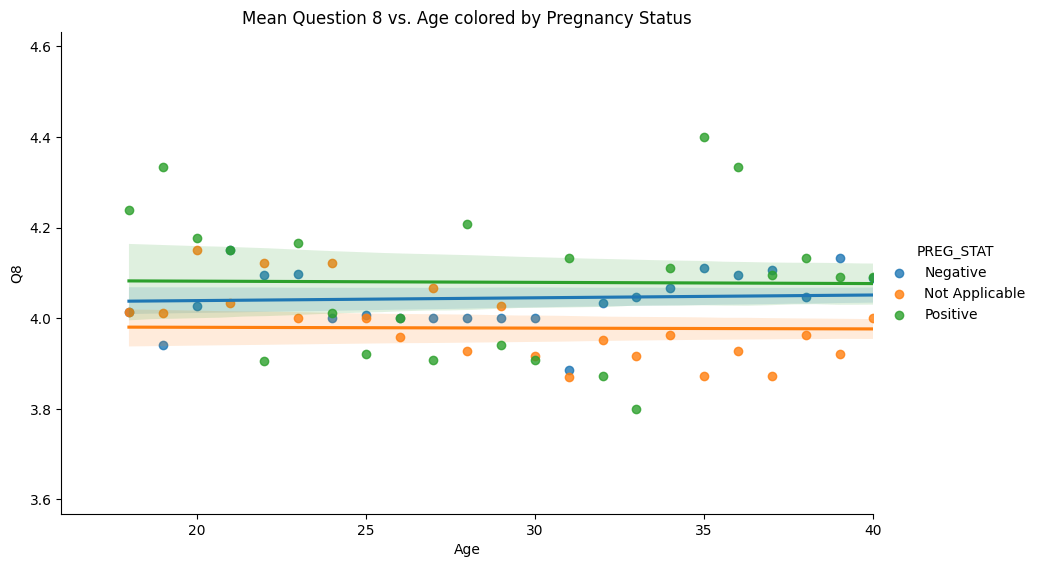

In [71]:
score_types = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
score_type_to_question = {
    'Q1': 'Question 1',
    'Q2': 'Question 2',
    'Q3': 'Question 3',
    'Q4': 'Question 4',
    'Q5': 'Question 5',
    'Q6': 'Question 6',
    'Q7': 'Question 7',
    'Q8': 'Question 8'
}

for score_type in score_types:
    grouped_scores = df_final.groupby(['AGE', 'PREG_STAT'])[score_type].median().reset_index()

    g = sns.lmplot(x='AGE', y=score_type, data=grouped_scores, hue='PREG_STAT', height=6, aspect=1.5, legend_out=True)

    plt.title(f'Mean {score_type_to_question[score_type]} vs. Age colored by Pregnancy Status')
    plt.xlabel('Age')
    plt.ylabel(score_type)
    plt.xlim(16, 40)

    plt.subplots_adjust(top=0.9)
    plt.show()

In [72]:
import itertools
import scipy.stats as stats

score_types = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

# Loop over each harm question
for score in score_types:
    print(f"\n=== T-test Results for {score} ===")

    # 1) Pairwise t-tests by HIV_STAT
    print("Comparisons by PREG_STAT:")
    hiv_groups = df_final['PREG_STAT'].dropna().unique()
    for grp1, grp2 in itertools.combinations(hiv_groups, 2):
        data1 = df_final.loc[df_final['PREG_STAT'] == grp1, score].dropna()
        data2 = df_final.loc[df_final['PREG_STAT'] == grp2, score].dropna()

        # Ensure both groups have at least 2 values to run a t-test
        if len(data1) >= 2 and len(data2) >= 2:
            t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            print(f"  {grp1} vs {grp2}: t = {t_stat:.3f}, p = {p_val:.3e}")
        else:
            print(f"  {grp1} vs {grp2}: Not enough data.")


=== T-test Results for Q1 ===
Comparisons by PREG_STAT:
  Not Applicable vs Negative: t = -1.945, p = 5.175e-02
  Not Applicable vs Positive: t = -0.950, p = 3.422e-01
  Negative vs Positive: t = -0.174, p = 8.622e-01

=== T-test Results for Q2 ===
Comparisons by PREG_STAT:
  Not Applicable vs Negative: t = -3.497, p = 4.712e-04
  Not Applicable vs Positive: t = -9.526, p = 1.230e-20
  Negative vs Positive: t = -8.049, p = 2.362e-15

=== T-test Results for Q3 ===
Comparisons by PREG_STAT:
  Not Applicable vs Negative: t = 5.203, p = 1.979e-07
  Not Applicable vs Positive: t = -0.162, p = 8.712e-01
  Negative vs Positive: t = -2.197, p = 2.829e-02

=== T-test Results for Q4 ===
Comparisons by PREG_STAT:
  Not Applicable vs Negative: t = -8.949, p = 3.901e-19
  Not Applicable vs Positive: t = -2.173, p = 3.005e-02
  Negative vs Positive: t = 1.632, p = 1.029e-01

=== T-test Results for Q5 ===
Comparisons by PREG_STAT:
  Not Applicable vs Negative: t = -6.842, p = 8.036e-12
  Not Applica